## Connect and Create a Graph

In [1]:
import pypgx.pg.rdbms.graph_server as graph_server
from pypgx import setloglevel

setloglevel("ROOT", "WARN")

base_url = "http://localhost:7007"
username = "graphuser2"
password = "WELcome789##"

instance = graph_server.get_instance(base_url, username, password)
session = instance.create_session("jupyter")
analyst = session.create_analyst()

print(session)

16:00:35.925 [main] WARN oracle.pgx.api.Pgx - connecting to a PGX server over unencrypted http; this configuration is insecure and must not be used in production
PgxSession(id: e73fbe67-71f0-43bc-a6c2-06e0e9c92675, name: jupyter)


In [2]:
statement = """
CREATE PROPERTY GRAPH graph2
  VERTEX TABLES (
    customer
      KEY (cst_id)
      LABEL customer
      PROPERTIES (cst_id, first_name, last_name)
  , account
      KEY (acc_id)
      LABEL account
      PROPERTIES (acc_id, cst_id)
  )
  EDGE TABLES (
    transaction
      KEY (txn_id)
      SOURCE KEY(acc_id_src) REFERENCES account
      DESTINATION KEY(acc_id_dst) REFERENCES account
      LABEL transferred_to
  , account
      KEY (acc_id)
      SOURCE KEY(cst_id) REFERENCES customer
      DESTINATION KEY(acc_id) REFERENCES account
      LABEL owns
  )
"""
session.prepare_pgql(statement).execute()

False

In [3]:
graph = session.get_graph("GRAPH2")
graph

PgxGraph(name: GRAPH2, v: 180000, e: 3103670, directed: True, memory(Mb): 212)

In [4]:
import time
setloglevel("ROOT", "INFO")
time_sta = time.time()
statement = """
SELECT *
FROM MATCH (a1:account)-/:transferred_to*/->(a2:account) ON graph2
WHERE a1.acc_id = 10
"""
session.prepare_pgql(statement).execute()
time_end = time.time()
print(time_end-time_sta)

0.6087243556976318


## Remove customer vertices

In [5]:
graph.destroy_vertex_property_if_exists("cst_first_name")
graph.destroy_vertex_property_if_exists("cst_last_name")
graph.create_vertex_property("string", "cst_first_name")
graph.create_vertex_property("string", "cst_last_name")

VertexProperty(name: cst_last_name, type: string, graph: GRAPH2)

In [6]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a SET (a.cst_first_name = c.first_name)
  FROM MATCH (a:account)<-[:owns]-(c:customer)
""")
graph

PgxGraph(name: sub-graph_265, v: 180000, e: 3103670, directed: True, memory(Mb): 235)

In [7]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a SET (a.cst_last_name = c.last_name)
  FROM MATCH (a:account)<-[:owns]-(c:customer)
""")
graph

PgxGraph(name: sub-graph_266, v: 180000, e: 3103670, directed: True, memory(Mb): 237)

In [8]:
graph = graph.clone(name="GRAPH3") 
graph.execute_pgql("""
DELETE c FROM MATCH (c:customer)
""")
graph

PgxGraph(name: GRAPH3, v: 180000, e: 3103670, directed: True, memory(Mb): 209)

In [9]:
session.query_pgql("""
  SELECT
    count(a)
  FROM MATCH (a) ON graph3
  LIMIT 50
""").print()

+----------+
| count(a) |
+----------+
| 100000   |
+----------+



In [10]:
session.query_pgql("""
  SELECT
    count(e)
  FROM MATCH ()-[e]->() ON graph3
  LIMIT 50
""").print()

+----------+
| count(e) |
+----------+
| 3003670  |
+----------+



In [11]:
session.query_pgql("""
  SELECT
    count(DISTINCT ID(v1)||ID(v2))
  FROM MATCH (v1)->(v2) ON graph3
  LIMIT 50
""").print()

+--------------------------------+
| count(DISTINCT ID(v1)||ID(v2)) |
+--------------------------------+
| 1573086                        |
+--------------------------------+



## Centrality

In [12]:
graph.destroy_vertex_property_if_exists("degree")
analyst.degree_centrality(graph)

00:57:35.906 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k7c_degree_centrality execution time = 1ms


VertexProperty(name: degree, type: integer, graph: GRAPH3)

In [13]:
graph.destroy_vertex_property_if_exists("in_degree")
analyst.in_degree_centrality(graph)

00:57:35.949 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k7b_indegree_centrality execution time = 1ms


VertexProperty(name: in_degree, type: integer, graph: GRAPH3)

In [14]:
graph.destroy_vertex_property_if_exists("out_degree")
analyst.out_degree_centrality(graph)

00:57:35.985 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k7a_outdegree_centrality execution time = 1ms


VertexProperty(name: out_degree, type: integer, graph: GRAPH3)

In [15]:
graph.destroy_vertex_property_if_exists("pagerank")
analyst.pagerank(graph)

00:57:36.061 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k1a_pagerank execution time = 30ms


VertexProperty(name: pagerank, type: double, graph: GRAPH3)

In [16]:
graph.destroy_vertex_property_if_exists("approx_betweenness")
analyst.approximate_vertex_betweenness_centrality(graph, 100)

00:57:39.142 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k3b_approx_node_betweenness_centrality execution time = 2123ms


VertexProperty(name: approx_betweenness, type: double, graph: GRAPH3)

In [17]:
graph.destroy_vertex_property_if_exists("eigenvector")
analyst.eigenvector_centrality(graph)

00:57:39.222 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k6_eigenvector_centrality execution time = 28ms


VertexProperty(name: eigenvector, type: double, graph: GRAPH3)

In [18]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY approx_betweenness DESC
  LIMIT 10
""").print()

+---------------------------------------------------------------------------------------------------------------+
| acc_id | degree | in_degree | out_degree | pagerank              | approx_betweenness | eigenvector           |
+---------------------------------------------------------------------------------------------------------------+
| 91131  | 84     | 34        | 50         | 1.178666077502724E-5  | 36697.56248413421  | 1.791294798267918E-5  |
| 20831  | 96     | 46        | 50         | 1.700289849069521E-5  | 28679.607885430392 | 1.454790550289573E-5  |
| 12196  | 89     | 39        | 50         | 1.0782856154974514E-5 | 26648.00848861359  | 1.598658217490742E-5  |
| 61336  | 85     | 35        | 50         | 1.0589636600292329E-5 | 26298.384715828084 | 1.8002888189884702E-5 |
| 96271  | 78     | 28        | 50         | 9.499506902490438E-6  | 25882.126331283795 | 1.5930543913417532E-5 |
| 32501  | 73     | 23        | 50         | 1.1246553672195665E-5 | 25491.618360005952 

## Community Detection

In [19]:
analyst.communities_label_propagation(graph)

00:57:39.583 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_c1_community_detection_label_propagation execution time = 177ms


PgxPartition(graph: GRAPH3, components: 20847)

In [20]:
analyst.communities_conductance_minimization(graph)
#analyst.communities_conductance_minimization(graph, max_iter=100)

00:57:49.702 [pgx-client-thread-1] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_c2_community_detection_conductance_minimization execution time = 9129ms


PgxPartition(graph: GRAPH3, components: 1477)

In [21]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.label_propagation
  , a.conductance_minimization
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY acc_id
  LIMIT 5
""").print()

+-------------------------------------------------------+
| acc_id | label_propagation | conductance_minimization |
+-------------------------------------------------------+
| 0      | 0                 | 0                        |
| 1      | 5336              | 55                       |
| 2      | 2629              | 0                        |
| 3      | 904               | 0                        |
| 4      | 4214              | 0                        |
+-------------------------------------------------------+



In [22]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.label_propagation
  , a.conductance_minimization
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
    AND a.conductance_minimization = 1
""").print()

+-------------------------------------------------------+
| acc_id | label_propagation | conductance_minimization |
+-------------------------------------------------------+
| 89649  | 7942              | 1                        |
| 83602  | 11021             | 1                        |
| 96962  | 11943             | 1                        |
| 93651  | 12832             | 1                        |
| 56852  | 8337              | 1                        |
| 73908  | 1                 | 1                        |
| 87781  | 8619              | 1                        |
| 45158  | 4309              | 1                        |
| 74303  | 18910             | 1                        |
| 86888  | 11978             | 1                        |
| 46906  | 10087             | 1                        |
| 16     | 1                 | 1                        |
| 78463  | 15581             | 1                        |
| 38460  | 536               | 1                        |
| 42284  | 318

## Add fraud flags

In [23]:
graph = graph.clone(name="GRAPH4")
graph

PgxGraph(name: GRAPH4, v: 100000, e: 3003670, directed: True, memory(Mb): 196)

In [24]:
graph = session.get_graph(name="GRAPH4")
graph

PgxGraph(name: GRAPH4, v: 100000, e: 3003670, directed: True, memory(Mb): 196)

In [25]:
graph.destroy_vertex_property_if_exists("is_fraud")
graph.create_vertex_property("boolean", "is_fraud")

VertexProperty(name: is_fraud, type: boolean, graph: GRAPH4)

In [26]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.approx_betweenness
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.approx_betweenness DESC
  LIMIT 10
  OFFSET 3000
""").print()

+-----------------------------+
| acc_id | approx_betweenness |
+-----------------------------+
| 31354  | 1278.3424371711071 |
| 44224  | 1278.242917036668  |
| 40501  | 1278.0957690217017 |
| 55445  | 1278.0423111544153 |
| 25822  | 1277.5755021375512 |
| 68640  | 1277.4750435360706 |
| 89465  | 1277.1234881234222 |
| 5055   | 1276.790458624101  |
| 8005   | 1276.5921859435857 |
| 92850  | 1276.4008922407281 |
+-----------------------------+



In [27]:
graph = graph.clone_and_execute_pgql("""
UPDATE x SET (x.is_fraud = true) FROM MATCH (x:account)
WHERE x.approx_betweenness > 1259.9120208559327
  AND x.acc_id % 3 = 0
""")
graph

PgxGraph(name: sub-graph_274, v: 100000, e: 3003670, directed: True, memory(Mb): 196)

In [28]:
graph.query_pgql("""
  SELECT COUNT(*)
  FROM MATCH (a)
  WHERE a.is_fraud = true
""").print()

+----------+
| COUNT(*) |
+----------+
| 1058     |
+----------+



In [29]:
graph.query_pgql("""
  SELECT a.conductance_minimization, COUNT(*)
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  GROUP BY a.conductance_minimization
  ORDER BY COUNT(*) DESC
  LIMIT 20
""").print()

+-------------------------------------+
| conductance_minimization | COUNT(*) |
+-------------------------------------+
| 0                        | 65374    |
| 97                       | 179      |
| 499                      | 141      |
| 46                       | 109      |
| 6                        | 105      |
| 44                       | 104      |
| 411                      | 99       |
| 1416                     | 88       |
| 255                      | 87       |
| 18                       | 86       |
| 19                       | 79       |
| 315                      | 78       |
| 1079                     | 78       |
| 350                      | 77       |
| 491                      | 77       |
| 442                      | 76       |
| 944                      | 75       |
| 343                      | 75       |
| 1169                     | 75       |
| 1267                     | 74       |
+-------------------------------------+



In [30]:
graph = graph.clone_and_execute_pgql("""
UPDATE x SET (x.is_fraud = true) FROM MATCH (x:account)
WHERE x.conductance_minimization IN (98, 297, 537, 82, 1103, 344, 1235)
  AND x.acc_id % 3 = 0
""")
graph

PgxGraph(name: sub-graph_277, v: 100000, e: 3003670, directed: True, memory(Mb): 196)

In [31]:
graph.query_pgql("""
  SELECT COUNT(*)
  FROM MATCH (a)
  WHERE a.is_fraud = true
""").print()

+----------+
| COUNT(*) |
+----------+
| 1088     |
+----------+



## Closeness to Known Fraud Accounts

In [32]:
#rs = graph.query_pgql("SELECT ID(a) FROM MATCH (a) WHERE a.is_fraud = true")
#vertices = graph.create_vertex_set()
#for i in rs:
#    vertices.add(graph.get_vertex(i))
#graph.destroy_vertex_property_if_exists("fraud_closeness")
#analyst.personalized_pagerank(graph, vertex, rank="fraud_closeness")

In [33]:
import pypgx
vertices = graph.get_vertices(pypgx.VertexFilter("vertex.is_fraud=TRUE"))
graph.destroy_vertex_property_if_exists("fraud_closeness")
analyst.personalized_pagerank(graph, vertices, rank="fraud_closeness")

00:57:51.072 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k2b_personalized_pagerank_from_set execution time = 346ms


VertexProperty(name: fraud_closeness, type: double, graph: sub-graph_277)

In [34]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.fraud_closeness
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_closeness DESC
  LIMIT 10
""").print()

+--------------------------------+
| acc_id | fraud_closeness       |
+--------------------------------+
| 37557  | 2.1821957847542988E-4 |
| 25236  | 2.1721728468897432E-4 |
| 44247  | 1.9939875214408076E-4 |
| 46383  | 1.986494062417016E-4  |
| 42738  | 1.9665861494360033E-4 |
| 57390  | 1.9557493630369198E-4 |
| 35670  | 1.9552232923198654E-4 |
| 14670  | 1.9358076775027606E-4 |
| 19977  | 1.9327094081806386E-4 |
| 71019  | 1.9081155413327354E-4 |
+--------------------------------+



## Calculate fraud_neighbors

In [35]:
graph.destroy_vertex_property_if_exists("in_fraud_neighbors")
graph.destroy_vertex_property_if_exists("out_fraud_neighbors")
graph.destroy_vertex_property_if_exists("fraud_neighbors")
graph.create_vertex_property("integer", "in_fraud_neighbors")
graph.create_vertex_property("integer", "out_fraud_neighbors")
graph.create_vertex_property("integer", "fraud_neighbors")

VertexProperty(name: fraud_neighbors, type: integer, graph: sub-graph_277)

In [36]:
graph.query_pgql("""
  SELECT ID(a1), COUNT(t1), a1.fraud_closeness
  FROM MATCH (a1)<-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
  LIMIT 10
""").print()

+----------------------------------------------------+
| ID(a1)         | COUNT(t1) | fraud_closeness       |
+----------------------------------------------------+
| ACCOUNT(64879) | 1         | 2.0724273892074026E-5 |
| ACCOUNT(48106) | 1         | 1.7147487030295423E-5 |
| ACCOUNT(24757) | 2         | 2.028666098667147E-5  |
| ACCOUNT(48138) | 2         | 1.2249400475085923E-5 |
| ACCOUNT(64895) | 3         | 1.7397900869482503E-5 |
| ACCOUNT(48170) | 2         | 1.1723121670371784E-5 |
| ACCOUNT(64943) | 3         | 2.1558973310259608E-5 |
| ACCOUNT(24853) | 1         | 1.1090152339127296E-5 |
| ACCOUNT(49658) | 1         | 2.1713979411015628E-5 |
| ACCOUNT(49642) | 1         | 9.736267464804329E-6  |
+----------------------------------------------------+



In [37]:
graph.query_pgql("""
  SELECT ID(a1), COUNT(t1), a1.fraud_closeness
  FROM MATCH (a1)-[t1:transferred_to]->(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
  LIMIT 10
""").print()

+----------------------------------------------------+
| ID(a1)         | COUNT(t1) | fraud_closeness       |
+----------------------------------------------------+
| ACCOUNT(64879) | 3         | 2.0724273892074026E-5 |
| ACCOUNT(24757) | 1         | 2.028666098667147E-5  |
| ACCOUNT(48138) | 3         | 1.2249400475085923E-5 |
| ACCOUNT(64895) | 5         | 1.7397900869482503E-5 |
| ACCOUNT(64943) | 2         | 2.1558973310259608E-5 |
| ACCOUNT(24853) | 2         | 1.1090152339127296E-5 |
| ACCOUNT(49658) | 1         | 2.1713979411015628E-5 |
| ACCOUNT(49642) | 1         | 9.736267464804329E-6  |
| ACCOUNT(24917) | 1         | 1.4456796808648529E-5 |
| ACCOUNT(65071) | 3         | 9.370620513339237E-6  |
+----------------------------------------------------+



In [38]:
graph.query_pgql("""
  SELECT ID(a1), COUNT(DISTINCT a2), COUNT(t1) AS cnt, a1.fraud_closeness
  FROM MATCH (a1)-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
  LIMIT 10
""").print()

+-------------------------------------------------------------------+
| ID(a1)         | COUNT(DISTINCT a2) | cnt | fraud_closeness       |
+-------------------------------------------------------------------+
| ACCOUNT(48106) | 1                  | 1   | 1.7147487030295423E-5 |
| ACCOUNT(64879) | 1                  | 4   | 2.0724273892074026E-5 |
| ACCOUNT(24757) | 1                  | 3   | 2.028666098667147E-5  |
| ACCOUNT(48138) | 1                  | 5   | 1.2249400475085923E-5 |
| ACCOUNT(64895) | 1                  | 8   | 1.7397900869482503E-5 |
| ACCOUNT(64943) | 1                  | 5   | 2.1558973310259608E-5 |
| ACCOUNT(48170) | 1                  | 2   | 1.1723121670371784E-5 |
| ACCOUNT(24853) | 1                  | 3   | 1.1090152339127296E-5 |
| ACCOUNT(49658) | 1                  | 2   | 2.1713979411015628E-5 |
| ACCOUNT(49642) | 1                  | 2   | 9.736267464804329E-6  |
+-------------------------------------------------------------------+



In [39]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a1 SET (a1.in_fraud_neighbors = COUNT(t1))
  FROM MATCH (a1)<-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
""")
graph

PgxGraph(name: sub-graph_284, v: 100000, e: 3003670, directed: True, memory(Mb): 198)

In [40]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a1 SET (a1.out_fraud_neighbors = COUNT(t1))
  FROM MATCH (a1)-[t1:transferred_to]->(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
""")
graph

PgxGraph(name: sub-graph_285, v: 100000, e: 3003670, directed: True, memory(Mb): 198)

In [41]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a1 SET (a1.fraud_neighbors = COUNT(t1))
  FROM MATCH (a1)-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
""")
graph

PgxGraph(name: sub-graph_286, v: 100000, e: 3003670, directed: True, memory(Mb): 198)

## Add fraud flags for high fraud_neighbours accounts

In [42]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.fraud_neighbors
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_neighbors DESC
  LIMIT 10
  OFFSET 3000
""").print()

+--------------------------+
| acc_id | fraud_neighbors |
+--------------------------+
| 68024  | 6               |
| 65713  | 6               |
| 27684  | 6               |
| 88408  | 6               |
| 27924  | 6               |
| 32915  | 6               |
| 51490  | 6               |
| 50914  | 6               |
| 54950  | 6               |
| 53574  | 6               |
+--------------------------+



In [43]:
graph = graph.clone_and_execute_pgql("""
UPDATE x SET (x.is_fraud = true) FROM MATCH (x:account)
WHERE x.fraud_neighbors > 6
  AND x.acc_id % 3 = 0
""")
graph

PgxGraph(name: sub-graph_288, v: 100000, e: 3003670, directed: True, memory(Mb): 198)

In [44]:
graph.query_pgql("""
  SELECT COUNT(*)
  FROM MATCH (a)
  WHERE a.is_fraud = true
""").print()

+----------+
| COUNT(*) |
+----------+
| 1548     |
+----------+



## Calculate fraud_closeness_2

In [45]:
import pypgx
vertices = graph.get_vertices(pypgx.VertexFilter("vertex.is_fraud=TRUE"))
graph.destroy_vertex_property_if_exists("fraud_closeness_2")
analyst.personalized_pagerank(graph, vertices, rank="fraud_closeness_2")

00:57:52.443 [pgx-client-thread-0] INFO oracle.pgx.api.internal.AbstractBuiltinAlgorithms - pgx_builtin_k2b_personalized_pagerank_from_set execution time = 353ms


VertexProperty(name: fraud_closeness_2, type: double, graph: sub-graph_288)

In [46]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.fraud_closeness
  , a.fraud_closeness_2
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_closeness DESC
  LIMIT 10
""").print()

+--------------------------------------------------------+
| acc_id | fraud_closeness       | fraud_closeness_2     |
+--------------------------------------------------------+
| 37557  | 2.1821957847542988E-4 | 1.6326049807522533E-4 |
| 25236  | 2.1721728468897432E-4 | 1.739786316869206E-4  |
| 44247  | 1.9939875214408076E-4 | 1.4388406745411577E-4 |
| 46383  | 1.986494062417016E-4  | 1.425670305793156E-4  |
| 42738  | 1.9665861494360033E-4 | 1.425774651214307E-4  |
| 57390  | 1.9557493630369198E-4 | 1.4723225792390336E-4 |
| 35670  | 1.9552232923198654E-4 | 1.4786250463109927E-4 |
| 14670  | 1.9358076775027606E-4 | 1.7663317159178352E-4 |
| 19977  | 1.9327094081806386E-4 | 1.3932575771698845E-4 |
| 71019  | 1.9081155413327354E-4 | 1.3655747183062035E-4 |
+--------------------------------------------------------+



In [47]:
graph.query_pgql("""
  SELECT
    a.is_fraud
  , AVG(a.fraud_closeness)
  , AVG(a.fraud_closeness_2)
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  GROUP BY is_fraud
""").print()

+--------------------------------------------------------------+
| is_fraud | AVG(a.fraud_closeness) | AVG(a.fraud_closeness_2) |
+--------------------------------------------------------------+
| false    | 8.310933456375178E-6   | 8.287794907261632E-6     |
| true     | 1.1742047643643394E-4  | 1.188933424151551E-4     |
+--------------------------------------------------------------+



## Store Features to Data Frame

In [48]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.acc_id
""")

In [49]:
df = rs.to_pandas()
df

,acc_id,cst_id,cst_first_name,cst_last_name,degree,in_degree,out_degree,pagerank,approx_betweenness,eigenvector,label_propagation,conductance_minimization,fraud_neighbors,in_fraud_neighbors,out_fraud_neighbors,fraud_closeness,is_fraud
0,0,0,Lucy,Yaple,53,13,40,0.000004,70.648731,0.000018,0,0,0,0,0,0.000002,false
1,1,1,Robin,Booth,28,8,20,0.000003,15.934567,0.000007,5336,55,0,0,0,0.000001,false
2,2,2,Kim,Taylor,16,6,10,0.000003,41.027432,0.000003,2629,0,0,0,0,0.000001,false
3,3,3,Stacy,Glover,37,17,20,0.000004,88.279389,0.000008,904,0,2,1,1,0.000005,false
4,4,4,Kristopher,Johnson,27,7,20,0.000003,55.815209,0.000006,4214,0,0,0,0,0.000002,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,19995,Merle,Hooks,55,25,30,0.000008,186.807557,0.000011,13027,209,0,0,0,0.000007,false
99996,99996,19996,Nancy,Darrah,56,36,20,0.000013,823.852640,0.000006,8116,0,5,3,2,0.000039,false
99997,99997,19997,Erica,Humphreys,46,26,20,0.000007,96.975595,0.000007,7100,0,1,0,1,0.000005,false
99998,99998,19998,Alberta,Stewart,59,19,40,0.000007,108.252139,0.000012,14388,0,0,0,0,0.000005,false


In [50]:
df.to_csv('./features_v3_100k.csv')

In [51]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_closeness DESC
""")

In [52]:
rs_df = rs.to_pandas()
rs_df

,acc_id,cst_id,cst_first_name,cst_last_name,degree,in_degree,out_degree,pagerank,approx_betweenness,eigenvector,label_propagation,conductance_minimization,fraud_neighbors,in_fraud_neighbors,out_fraud_neighbors,fraud_closeness,is_fraud
0,37557,37557,David,Raap,87,37,50,0.000016,1484.415004,0.000019,2625,175,15,7,8,2.182196e-04,true
1,25236,25236,Margo,Ehrlich,59,39,20,0.000021,1981.889187,0.000004,3138,0,8,6,2,2.172173e-04,true
2,44247,44247,Ann,Wright,82,32,50,0.000015,1602.463512,0.000014,13424,192,6,3,3,1.993988e-04,true
3,46383,46383,Benjamin,Leroy,81,31,50,0.000018,1633.798550,0.000014,3830,0,5,3,2,1.986494e-04,true
4,42738,42738,Dana,Weaver,84,34,50,0.000014,23681.436966,0.000015,8380,546,28,11,17,1.966586e-04,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,228,228,Katherine,Jones,24,4,20,0.000002,0.493682,0.000004,3703,0,0,0,0,3.405622e-07,false
99996,245,245,Nancy,Merten,23,3,20,0.000002,7.039134,0.000005,8763,0,0,0,0,3.382386e-07,false
99997,387,387,Martha,Shumaker,42,2,40,0.000002,31.788301,0.000013,11445,897,0,0,0,2.566463e-07,false
99998,981,981,Bertha,Jackson,22,2,20,0.000002,3.705932,0.000005,15749,0,0,0,0,2.194373e-07,false


## ML

In [53]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE a.is_fraud = true
  ORDER BY a.fraud_closeness DESC
""")
df_true = rs.to_pandas()
df_true

,acc_id,cst_id,cst_first_name,cst_last_name,degree,in_degree,out_degree,pagerank,approx_betweenness,eigenvector,label_propagation,conductance_minimization,fraud_neighbors,in_fraud_neighbors,out_fraud_neighbors,fraud_closeness,is_fraud
0,37557,37557,David,Raap,87,37,50,0.000016,1484.415004,0.000019,2625,175,15,7,8,0.000218,true
1,25236,25236,Margo,Ehrlich,59,39,20,0.000021,1981.889187,0.000004,3138,0,8,6,2,0.000217,true
2,44247,44247,Ann,Wright,82,32,50,0.000015,1602.463512,0.000014,13424,192,6,3,3,0.000199,true
3,46383,46383,Benjamin,Leroy,81,31,50,0.000018,1633.798550,0.000014,3830,0,5,3,2,0.000199,true
4,42738,42738,Dana,Weaver,84,34,50,0.000014,23681.436966,0.000015,8380,546,28,11,17,0.000197,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,70068,70068,Michael,Yost,64,14,50,0.000005,132.608220,0.000019,7884,255,7,1,6,0.000007,true
1544,81318,1318,Darryl,Hussein,61,11,50,0.000005,436.270369,0.000020,5064,0,7,1,6,0.000006,true
1545,72189,72189,Julie,Krause,62,12,50,0.000005,115.944394,0.000014,18759,0,7,1,6,0.000006,true
1546,120,120,Patricia,Kroeger,57,7,50,0.000003,66.804091,0.000012,18086,0,9,1,8,0.000004,true


In [54]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE a.is_fraud = false
  LIMIT 1853
""")
df_false = rs.to_pandas()
df_false

,acc_id,cst_id,cst_first_name,cst_last_name,degree,in_degree,out_degree,pagerank,approx_betweenness,eigenvector,label_propagation,conductance_minimization,fraud_neighbors,in_fraud_neighbors,out_fraud_neighbors,fraud_closeness,is_fraud
0,1297,1297,Kim,Hernandez,46,6,40,0.000003,31.302941,0.000010,5409,0,0,0,0,0.000001,false
1,1313,1313,Thomas,Dixon,61,11,50,0.000004,80.661148,0.000020,5410,0,0,0,0,0.000002,false
2,1329,1329,Harold,Barnes,48,8,40,0.000004,295.768244,0.000011,5411,280,0,0,0,0.000001,false
3,1345,1345,Marie,Gaston,26,16,10,0.000005,48.965403,0.000003,5412,0,0,0,0,0.000004,false
4,1361,1361,Jason,Meadows,32,22,10,0.000005,22.760858,0.000003,5413,0,0,0,0,0.000002,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,29921,29921,Elizabeth,Abernethy,86,56,30,0.000015,825.658686,0.000012,1538,0,0,0,0,0.000012,false
1849,29937,29937,Roger,Mccray,65,25,40,0.000009,96.369237,0.000013,6589,0,0,0,0,0.000005,false
1850,29953,29953,Melissa,Alexander,55,45,10,0.000014,104.984819,0.000002,3701,0,1,1,0,0.000012,false
1851,29969,29969,Garth,Sandoval,72,42,30,0.000014,214.953464,0.000010,6590,0,0,0,0,0.000012,false


In [55]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
from DAML.AMLFrameworks.DecisionsAML import DAML


2022-10-07 00:58:14.804803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 00:58:14.949601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 00:58:14.949630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-07 00:58:14.978157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 00:58:15.817074: W tensorflow/stream_executor/platform/de

# Creating Datasets

# Dataset With Graph Features 

In [56]:
data = pd.read_csv("features_v4_100k.csv")
df = data.copy()
from sklearn.utils import resample
df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10 * len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
labels = df_upsampled["is_fraud"].astype(int)
data= df_upsampled.drop(["Unnamed: 0","acc_id","is_fraud",'cst_id', 'cst_first_name', 'cst_last_name'],axis=1)
XTRAIN_with_graph,XTEST_with_graph,YTRAIN_with_graph,YTEST_with_graph = train_test_split(data, labels, test_size=0.10, random_state=7)

# Dataset without Graph Features

In [57]:
data = pd.read_csv("features_v4_100k.csv")
df = data.copy()
from sklearn.utils import resample
df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10 * len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
labels = df_upsampled["is_fraud"].astype(int)
data= df_upsampled.drop(["Unnamed: 0","acc_id","is_fraud",'cst_id', 'cst_first_name', 'cst_last_name'],axis=1)
data = data[['in_degree', 'out_degree', 'fraud_neighbors','in_fraud_neighbors',
        'out_fraud_neighbors']]
XTRAIN_without_graph,XTEST_without_graph,YTRAIN_without_graph,YTEST_without_graph = train_test_split(data, labels, test_size=0.10, random_state=7)

# Features used when training with Graph Features

In [58]:
XTRAIN_with_graph.columns

Index(['degree', 'in_degree', 'out_degree', 'pagerank', 'approx_betweenness',
       'eigenvector', 'label_propagation', 'conductance_minimization',
       'fraud_neighbors', 'in_fraud_neighbors', 'out_fraud_neighbors',
       'fraud_closeness'],
      dtype='object')

# Features used when training without Graph features 

In [59]:
XTRAIN_without_graph.columns

Index(['in_degree', 'out_degree', 'fraud_neighbors', 'in_fraud_neighbors',
       'out_fraud_neighbors'],
      dtype='object')

# Training without Graph Features 

In [60]:
daml_obj = DAML()
start_time = time.time()

final_eval_rankings,k_fold_results = daml_obj.fit(train_x=XTRAIN_without_graph,train_y=YTRAIN_without_graph,val_x=XTEST_without_graph,val_y=YTEST_without_graph,criteria="f1",folds=7)

print("--- %s seconds ---" % (time.time() - start_time))


Threshold value  9223372036854775807


/home/opc/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[I 2022-10-07 00:58:19,905] A new study created in memory with name: no-name-c09a1adb-b105-4b7b-8ef9-2d5bbcd91cbe


Mode of execution : performance
Tuning Type : default
Criteria of optimization : f1
Number of folds being used : 7
Models being run : ['xgboost', 'lightgbm', 'knn', 'catboost', 'extratrees']
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10
[00:58:19] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.
Fixed parameter 'learning_rate' with value 0.3 is out of range for distribution UniformDistribution(high=0.2, low=0.001).
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:58:21,097] Trial 0 finished with value: 0.15555555555555556 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.15663032228857535, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 1, 'gamma': 0, 'objective': 'binary:logistic', 'colsample_bytre

[[12609    18]
 [  210    21]]
[00:58:21] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:58:26,738] Trial 1 finished with value: 0.34416826003824097 and parameters: {'n_estimators': 214, 'max_depth': 22, 'learning_rate': 0.06554535792519323, 'reg_alpha': 1.1159655293955673, 'reg_lambda': 4.960859623024625, 'min_child_weight': 0.5121583398972246, 'gamma': 3.189584581324208, 'objective': 'reg:logistic', 'colsample_bytree': 0.9985864796521684, 'colsample_bynode': 0.7720358157435914, 'colsample_bylevel': 0.753171372154221, 'subsample': 0.7595347799852932, 'booster': 'gbtree', 'tree_method': 'auto', 'scale_pos_weight': 7.601926950992322}. Best is trial 1 with value: 0.34416826003824097.


[[12425   202]
 [  141    90]]
[00:58:26] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 00:58:29,463] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 896, 'max_depth': 3, 'learning_rate': 0.01880225644830314, 'reg_alpha': 3.6578280855168233, 'reg_lambda': 4.960135831101827, 'min_child_weight': 2.0933651699273708, 'gamma': 0.08813749476453414, 'objective': 'binary:logistic', 'colsample_bytree': 0.4925516698876792, 'colsample_bynode': 0.47777323433496643, 'colsample_bylevel': 0.28550109795261275, 'subsample': 0.6534388117420291, 'booster': 'gblinear', 'tree_method': 'exact', 'scale_pos_weight': 15.845493735

[[12627     0]
 [  231     0]]
[00:58:29] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:58:40,320] Trial 3 finished with value: 0.3123028391167192 and parameters: {'n_estimators': 701, 'max_depth': 23, 'learning_rate': 0.07719247077332644, 'reg_alpha': 2.3878039299612914, 'reg_lambda': 2.6703468378972417, 'min_child_weight': 3.1963044263492897, 'gamma': 2.227155276631978, 'objective': 'binary:logistic', 'colsample_bytree': 0.7384306081279182, 'colsample_bynode': 0.42181227532104926, 'colsample_bylevel': 0.8888283365279978, 'subsample': 0.9623683984455447, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 13.251938493006953}. Best is trial 1 with value: 0.34416826003824097.


[[12323   304]
 [  132    99]]
[00:58:40] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:58:41,159] Trial 4 finished with value: 0.3442940038684719 and parameters: {'n_estimators': 195, 'max_depth': 11, 'learning_rate': 0.0016458735455067972, 'reg_alpha': 1.999781535177556, 'reg_lambda': 0.5482136653487507, 'min_child_weight': 0.7922411790578116, 'gamma': 1.593150155473659, 'objective': 'reg:logistic', 'colsample_bytree': 0.7008066105625497, 'colsample_bynode': 0.3094136944136674, 'colsample_bylevel': 0.5755972085815692, 'subsample': 0.8270567147177796, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 14.357279862202766}. Best is trial 4 with value: 0.3442940038684719.


[[12430   197]
 [  142    89]]
[00:58:41] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:58:53,305] Trial 5 finished with value: 0.2904191616766467 and parameters: {'n_estimators': 853, 'max_depth': 20, 'learning_rate': 0.1141849218391255, 'reg_alpha': 3.987115265674354, 'reg_lambda': 0.5760904757132385, 'min_child_weight': 3.85245339275642, 'gamma': 1.9637892421206848, 'objective': 'binary:logistic', 'colsample_bytree': 0.4841172606245897, 'colsample_bynode': 0.591498698992627, 'colsample_bylevel': 0.5033569335651241, 'subsample': 0.6166256843056441, 'booster': 'gbtree', 'tree_method': 'auto', 'scale_pos_weight': 14.338888972300488}. Best is trial 4 with value: 0.3442940038684719.


[[12287   340]
 [  134    97]]
[00:58:53] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:58:57,373] Trial 6 finished with value: 0.2942008486562942 and parameters: {'n_estimators': 228, 'max_depth': 25, 'learning_rate': 0.09014885171865525, 'reg_alpha': 0.5272860600461887, 'reg_lambda': 1.9236631862504183, 'min_child_weight': 0.2613074717970726, 'gamma': 2.7391841793530785, 'objective': 'binary:logistic', 'colsample_bytree': 0.7961293474638331, 'colsample_bynode': 0.8666121427756129, 'colsample_bylevel': 0.7255335645087171, 'subsample': 0.6065937005170764, 'booster': 'gbtree', 'tree_method': 'auto', 'scale_pos_weight': 19.882324479753155}. Best is trial 4 with value: 0.3442940038684719.


[[12255   372]
 [  127   104]]
[00:58:57] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:05,115] Trial 7 finished with value: 0.33712984054669703 and parameters: {'n_estimators': 649, 'max_depth': 16, 'learning_rate': 0.17729531383070626, 'reg_alpha': 2.5363194631254253, 'reg_lambda': 1.3049769931142126, 'min_child_weight': 0.7278037485424632, 'gamma': 3.271065759868452, 'objective': 'binary:logistic', 'colsample_bytree': 0.24093364242963491, 'colsample_bynode': 0.47345967724197446, 'colsample_bylevel': 0.14409169884309678, 'subsample': 0.7903537664233662, 'booster': 'gbtree', 'tree_method': 'auto', 'scale_pos_weight': 2.967895562443752}. Best is trial 4 with value: 0.3442940038684719.


[[12493   134]
 [  157    74]]
[00:59:05] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:07,047] Trial 8 finished with value: 0.34893617021276596 and parameters: {'n_estimators': 516, 'max_depth': 16, 'learning_rate': 0.17403941630736627, 'reg_alpha': 3.746503846833863, 'reg_lambda': 0.11141369111567268, 'min_child_weight': 3.254470278948217, 'gamma': 4.969032986473581, 'objective': 'reg:logistic', 'colsample_bytree': 0.5277770543024876, 'colsample_bynode': 0.6795394202376472, 'colsample_bylevel': 0.5264542359751572, 'subsample': 0.9547006654980338, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 5.315210760590756}. Best is trial 8 with value: 0.34893617021276596.


[[12470   157]
 [  149    82]]
[00:59:07] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:10,150] Trial 9 finished with value: 0.35180722891566263 and parameters: {'n_estimators': 679, 'max_depth': 18, 'learning_rate': 0.19977652578243152, 'reg_alpha': 0.2162259301874503, 'reg_lambda': 0.24994747019407682, 'min_child_weight': 0.6859756371917364, 'gamma': 0.32224349748772085, 'objective': 'reg:logistic', 'colsample_bytree': 0.794960065275501, 'colsample_bynode': 0.29033339472254804, 'colsample_bylevel': 0.7190366021730785, 'subsample': 0.7693286047316468, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 3.403735488134101}. Best is trial 9 with value: 0.35180722891566263.


[[12516   111]
 [  158    73]]
[00:59:10] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 00:59:11,547] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 442, 'max_depth': 11, 'learning_rate': 0.13384647022270685, 'reg_alpha': 4.807045603701334, 'reg_lambda': 2.992828265083855, 'min_child_weight': 2.1064281027948657, 'gamma': 0.986970955242138, 'objective': 'reg:logistic', 'colsample_bytree': 0.15618927303424612, 'colsample_bynode': 0.13052237295170752, 'colsample_bylevel': 0.34563007724121264, 'subsample': 0.5102807246270322, 'booster': 'gblinear', 'tree_method': 'approx', 'scale_pos_weight': 8.892181557091

[[12627     0]
 [  231     0]]
[00:59:11] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 00:59:13,050] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 475, 'max_depth': 17, 'learning_rate': 0.1978072702918255, 'reg_alpha': 3.4717707290999296, 'reg_lambda': 0.45121662963033005, 'min_child_weight': 4.587661407022901, 'gamma': 4.8008599396873635, 'objective': 'reg:logistic', 'colsample_bytree': 0.35951350095345924, 'colsample_bynode': 0.6693771996215672, 'colsample_bylevel': 0.582561598902171, 'subsample': 0.8851902708895651, 'booster': 'gblinear', 'tree_method': 'hist', 'scale_pos_weight': 5.020513447626809

[[12627     0]
 [  231     0]]
[00:59:13] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:15,702] Trial 12 finished with value: 0.34858387799564267 and parameters: {'n_estimators': 612, 'max_depth': 14, 'learning_rate': 0.19752683088518888, 'reg_alpha': 1.4831950897615982, 'reg_lambda': 0.0047263172626190175, 'min_child_weight': 2.916157349660575, 'gamma': 4.695133661297707, 'objective': 'reg:logistic', 'colsample_bytree': 0.6218666155759452, 'colsample_bynode': 0.22522180204349368, 'colsample_bylevel': 0.7446882538011796, 'subsample': 0.8925118350179153, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 5.458020024430969}. Best is trial 9 with value: 0.35180722891566263.


[[12479   148]
 [  151    80]]
[00:59:15] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 00:59:18,443] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 750, 'max_depth': 18, 'learning_rate': 0.1609321541737267, 'reg_alpha': 3.054062054442346, 'reg_lambda': 1.8358592539333445, 'min_child_weight': 1.7415462417620806, 'gamma': 3.7421187736815815, 'objective': 'reg:logistic', 'colsample_bytree': 0.8754836891610549, 'colsample_bynode': 0.33713344970619746, 'colsample_bylevel': 0.45707520305293226, 'subsample': 0.6849355393323288, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 0.3556885337558713

[[12627     0]
 [  231     0]]
[00:59:18] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:19,959] Trial 14 finished with value: 0.3524416135881104 and parameters: {'n_estimators': 396, 'max_depth': 10, 'learning_rate': 0.13479881946834615, 'reg_alpha': 4.586694053396737, 'reg_lambda': 3.638721656401974, 'min_child_weight': 3.4858424995277093, 'gamma': 1.0206579271594904, 'objective': 'reg:logistic', 'colsample_bytree': 0.5746765930159587, 'colsample_bynode': 0.6598206634521226, 'colsample_bylevel': 0.6627418928716499, 'subsample': 0.8899570129498791, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 5.108193301588869}. Best is trial 14 with value: 0.3524416135881104.


[[12470   157]
 [  148    83]]
[00:59:20] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 00:59:21,031] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 330, 'max_depth': 10, 'learning_rate': 0.1303266200742321, 'reg_alpha': 4.750072832171958, 'reg_lambda': 3.8098741211907847, 'min_child_weight': 4.748296972675653, 'gamma': 1.0115551933644502, 'objective': 'reg:logistic', 'colsample_bytree': 0.6211681698328096, 'colsample_bynode': 0.1130270514570983, 'colsample_bylevel': 0.6611522887645639, 'subsample': 0.8543309727938464, 'booster': 'gblinear', 'tree_method': 'approx', 'scale_pos_weight': 11.04974381660713

[[12627     0]
 [  231     0]]
[00:59:21] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:22,775] Trial 16 finished with value: 0.3258145363408521 and parameters: {'n_estimators': 421, 'max_depth': 8, 'learning_rate': 0.14027562166743468, 'reg_alpha': 1.2051182002605225, 'reg_lambda': 3.6118617379349773, 'min_child_weight': 4.194556004674925, 'gamma': 0.8313585903809617, 'objective': 'reg:logistic', 'colsample_bytree': 0.8693009860224884, 'colsample_bynode': 0.6000410993554817, 'colsample_bylevel': 0.8371750853554935, 'subsample': 0.7162037742986429, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 2.9878174893071368}. Best is trial 14 with value: 0.3524416135881104.


[[12524   103]
 [  166    65]]
[00:59:22] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:25,106] Trial 17 finished with value: 0.36250000000000004 and parameters: {'n_estimators': 797, 'max_depth': 2, 'learning_rate': 0.04824172443504744, 'reg_alpha': 0.08409734760143683, 'reg_lambda': 4.0887993075857825, 'min_child_weight': 1.3731692474550194, 'gamma': 0.4992286440878273, 'objective': 'reg:logistic', 'colsample_bytree': 0.3836431305035207, 'colsample_bynode': 0.8216399543419126, 'colsample_bylevel': 0.8723670171093323, 'subsample': 0.7982334830542703, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 7.329074218701076}. Best is trial 17 with value: 0.36250000000000004.


[[12465   162]
 [  144    87]]
[00:59:25] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 00:59:27,643] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 833, 'max_depth': 2, 'learning_rate': 0.05083386828978548, 'reg_alpha': 4.310434026616803, 'reg_lambda': 4.313888005388416, 'min_child_weight': 1.3926357046563103, 'gamma': 1.5590754281676045, 'objective': 'reg:logistic', 'colsample_bytree': 0.363924172035455, 'colsample_bynode': 0.8617031572430318, 'colsample_bylevel': 0.9616567358306378, 'subsample': 0.9151480965681551, 'booster': 'gblinear', 'tree_method': 'hist', 'scale_pos_weight': 7.648485260264014}. 

[[12627     0]
 [  231     0]]
[00:59:27] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:45,616] Trial 19 finished with value: 0.3234782608695652 and parameters: {'n_estimators': 996, 'max_depth': 6, 'learning_rate': 0.0427528119280332, 'reg_alpha': 3.0494862905468416, 'reg_lambda': 3.3930436476996113, 'min_child_weight': 2.7054532084758582, 'gamma': 0.538471751569805, 'objective': 'reg:logistic', 'colsample_bytree': 0.4120460396388531, 'colsample_bynode': 0.7881807718716075, 'colsample_bylevel': 0.8421775775246436, 'subsample': 0.8705145929171791, 'booster': 'gbtree', 'tree_method': 'approx', 'scale_pos_weight': 10.85008995667957}. Best is trial 17 with value: 0.36250000000000004.


[[12376   251]
 [  138    93]]
[00:59:45] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:49,810] Trial 20 finished with value: 0.3568464730290456 and parameters: {'n_estimators': 363, 'max_depth': 4, 'learning_rate': 0.1071688804879013, 'reg_alpha': 1.831583308904143, 'reg_lambda': 4.236033895604775, 'min_child_weight': 3.7549443605334836, 'gamma': 1.4506277073171168, 'objective': 'reg:logistic', 'colsample_bytree': 0.21860284758403914, 'colsample_bynode': 0.9793228191922356, 'colsample_bylevel': 0.6428932955847402, 'subsample': 0.8170718351809151, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 8.14472293720668}. Best is trial 17 with value: 0.36250000000000004.


[[12462   165]
 [  145    86]]
[00:59:49] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:54,223] Trial 21 finished with value: 0.35833333333333334 and parameters: {'n_estimators': 360, 'max_depth': 4, 'learning_rate': 0.11132935854412451, 'reg_alpha': 1.779164212361505, 'reg_lambda': 4.1531153271228165, 'min_child_weight': 3.5186356485883157, 'gamma': 1.4313264245667392, 'objective': 'reg:logistic', 'colsample_bytree': 0.25451555024781386, 'colsample_bynode': 0.9418977127759848, 'colsample_bylevel': 0.6326637338742348, 'subsample': 0.8276111197747227, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 7.839539126781824}. Best is trial 17 with value: 0.36250000000000004.


[[12464   163]
 [  145    86]]
[00:59:54] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 00:59:58,438] Trial 22 finished with value: 0.3524590163934426 and parameters: {'n_estimators': 325, 'max_depth': 5, 'learning_rate': 0.10819271864366925, 'reg_alpha': 1.7978518025618786, 'reg_lambda': 4.355288862754296, 'min_child_weight': 3.904825444998936, 'gamma': 1.5494518169543559, 'objective': 'reg:logistic', 'colsample_bytree': 0.24814716514973267, 'colsample_bynode': 0.9985924917528466, 'colsample_bylevel': 0.40794583209480584, 'subsample': 0.8099237319317464, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 8.571300298388357}. Best is trial 17 with value: 0.36250000000000004.


[[12456   171]
 [  145    86]]
[00:59:58] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:00:05,597] Trial 23 finished with value: 0.35983263598326365 and parameters: {'n_estimators': 572, 'max_depth': 4, 'learning_rate': 0.08824657355030799, 'reg_alpha': 0.8580940682893552, 'reg_lambda': 4.2731384059854545, 'min_child_weight': 4.310482815821783, 'gamma': 1.4675847829129904, 'objective': 'reg:logistic', 'colsample_bytree': 0.10712331284484722, 'colsample_bynode': 0.9048131309171685, 'colsample_bylevel': 0.6395742516874902, 'subsample': 0.7304474761812653, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 6.7812939062090605}. Best is trial 17 with value: 0.36250000000000004.


[[12466   161]
 [  145    86]]
[01:00:05] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:00:11,607] Trial 24 finished with value: 0.35983263598326365 and parameters: {'n_estimators': 589, 'max_depth': 2, 'learning_rate': 0.08646865600767728, 'reg_alpha': 0.7447759707863654, 'reg_lambda': 3.1545752443942274, 'min_child_weight': 4.98188030908223, 'gamma': 0.5639260259782582, 'objective': 'reg:logistic', 'colsample_bytree': 0.10715120672334666, 'colsample_bynode': 0.8799676330610052, 'colsample_bylevel': 0.8918103007028965, 'subsample': 0.7283506552505605, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 6.636437947023631}. Best is trial 17 with value: 0.36250000000000004.


[[12466   161]
 [  145    86]]
[01:00:11] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:00:18,111] Trial 25 finished with value: 0.35772357723577236 and parameters: {'n_estimators': 603, 'max_depth': 2, 'learning_rate': 0.08739886091386441, 'reg_alpha': 0.7292259183720767, 'reg_lambda': 3.1063088404974, 'min_child_weight': 4.9152464475671795, 'gamma': 0.543979364686762, 'objective': 'reg:logistic', 'colsample_bytree': 0.10302207834362848, 'colsample_bynode': 0.8668551282963345, 'colsample_bylevel': 0.9081600650367916, 'subsample': 0.7302911127333908, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 10.06022924073365}. Best is trial 17 with value: 0.36250000000000004.


[[12454   173]
 [  143    88]]
[01:00:18] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:19,858] Trial 26 finished with value: 0.0 and parameters: {'n_estimators': 557, 'max_depth': 8, 'learning_rate': 0.04303450704474057, 'reg_alpha': 0.746905548466724, 'reg_lambda': 2.280831870877241, 'min_child_weight': 4.395524074298487, 'gamma': 1.9886135384289954, 'objective': 'reg:logistic', 'colsample_bytree': 0.1136147041174961, 'colsample_bynode': 0.7350990149366224, 'colsample_bylevel': 0.8283300116153974, 'subsample': 0.6974927915678073, 'booster': 'gblinear', 'tree_method': 'exact', 'scale_pos_weight': 6.418793715878033}.

[[12627     0]
 [  231     0]]
[01:00:19] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:00:28,759] Trial 27 finished with value: 0.3283018867924528 and parameters: {'n_estimators': 745, 'max_depth': 7, 'learning_rate': 0.05823269827584537, 'reg_alpha': 0.41016493539385, 'reg_lambda': 4.702980012390394, 'min_child_weight': 2.284332673981352, 'gamma': 0.641335651843392, 'objective': 'reg:logistic', 'colsample_bytree': 0.3167585638691093, 'colsample_bynode': 0.9124811339142339, 'colsample_bylevel': 0.9242292219998863, 'subsample': 0.639481020794251, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 12.023232265518995}. Best is trial 17 with value: 0.36250000000000004.
[I 2022-10-07 01:00:28,771] A new study created in memory with name: 

[[12415   212]
 [  144    87]]
 Early stopping the HPO as Patience is breached 
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.
[I 2022-10-07 01:00:29,020] Trial 0 finished with value: 0.01702127659574468 and parameters: {'n_estimators': 100, 'num_leaves': 31, 'max_depth': 10, 'max_bin': 255, 'min_data_in_leaf': 20, 'min_data_in_bin': 3, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 0 with value: 0.01702127659574468.


[[12625     2]
 [  229     2]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=3.5070572005873664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5070572005873664
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=251, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=251
[LightGBM] [Warning] lambda_l2 is set=4.0746973997175475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0746973997175475


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:29,419] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 259, 'num_leaves': 37, 'max_depth': 58, 'max_bin': 102, 'min_data_in_leaf': 251, 'min_data_in_bin': 174, 'lambda_l1': 3.5070572005873664, 'lambda_l2': 4.0746973997175475, 'learning_rate': 0.02065308067237055, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'is_unbalanced': True}. Best is trial 0 with value: 0.01702127659574468.


[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.0708709821854896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708709821854896
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=252, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=252
[LightGBM] [Warning] lambda_l2 is set=4.675299935766575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.675299935766575


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:29,683] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 153, 'num_leaves': 78, 'max_depth': 23, 'max_bin': 229, 'min_data_in_leaf': 252, 'min_data_in_bin': 78, 'lambda_l1': 1.0708709821854896, 'lambda_l2': 4.675299935766575, 'learning_rate': 0.04834983950639011, 'feature_fraction': 0.75, 'bagging_fraction': 0.75, 'is_unbalanced': True}. Best is trial 0 with value: 0.01702127659574468.


[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.884687542590738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.884687542590738
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] lambda_l2 is set=4.14550214969707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.14550214969707


[I 2022-10-07 01:00:29,967] Trial 3 finished with value: 0.01702127659574468 and parameters: {'n_estimators': 151, 'num_leaves': 106, 'max_depth': 134, 'max_bin': 251, 'min_data_in_leaf': 176, 'min_data_in_bin': 69, 'lambda_l1': 0.884687542590738, 'lambda_l2': 4.14550214969707, 'learning_rate': 0.19898235088274063, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'is_unbalanced': True}. Best is trial 0 with value: 0.01702127659574468.


[[12625     2]
 [  229     2]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.9100893803922083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9100893803922083
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=102, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=102
[LightGBM] [Warning] lambda_l2 is set=0.9641843831842511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9641843831842511


[I 2022-10-07 01:00:30,252] Trial 4 finished with value: 0.025423728813559324 and parameters: {'n_estimators': 153, 'num_leaves': 99, 'max_depth': 6, 'max_bin': 233, 'min_data_in_leaf': 102, 'min_data_in_bin': 252, 'lambda_l1': 0.9100893803922083, 'lambda_l2': 0.9641843831842511, 'learning_rate': 0.18339827581906365, 'feature_fraction': 0.75, 'bagging_fraction': 0.75, 'is_unbalanced': True}. Best is trial 4 with value: 0.025423728813559324.


[[12625     2]
 [  228     3]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=3.4083014921440875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4083014921440875
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] lambda_l2 is set=0.2419364225137638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2419364225137638


[I 2022-10-07 01:00:30,525] Trial 5 finished with value: 0.008620689655172414 and parameters: {'n_estimators': 171, 'num_leaves': 102, 'max_depth': 158, 'max_bin': 84, 'min_data_in_leaf': 175, 'min_data_in_bin': 63, 'lambda_l1': 3.4083014921440875, 'lambda_l2': 0.2419364225137638, 'learning_rate': 0.19794656120203832, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'is_unbalanced': True}. Best is trial 4 with value: 0.025423728813559324.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:30,640] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 40, 'num_leaves': 49, 'max_depth': 188, 'max_bin': 223, 'min_data_in_leaf': 88, 'min_data_in_bin': 169, 'lambda_l1': 2.187674023660426, 'lambda_l2': 2.4317553577809816, 'learning_rate': 0.12850447878705834, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': True}. Best is trial 4 with value: 0.025423728813559324.

[[12627     0]
 [  230     1]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=2.187674023660426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.187674023660426
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l2 is set=2.4317553577809816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4317553577809816
[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1.9506942971375603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9506942971375603
[LightGBM] [Warning] bagging_fraction is set=0.5, s

[I 2022-10-07 01:00:30,900] Trial 7 finished with value: 0.008583690987124463 and parameters: {'n_estimators': 149, 'num_leaves': 127, 'max_depth': 66, 'max_bin': 194, 'min_data_in_leaf': 224, 'min_data_in_bin': 45, 'lambda_l1': 1.9506942971375603, 'lambda_l2': 0.9733290096694303, 'learning_rate': 0.1716179566680044, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'is_unbalanced': False}. Best is trial 4 with value: 0.025423728813559324.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:31,019] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 44, 'num_leaves': 38, 'max_depth': 221, 'max_bin': 218, 'min_data_in_leaf': 205, 'min_data_in_bin': 27, 'lambda_l1': 0.5174942654370457, 'lambda_l2': 2.6705901253974873, 'learning_rate': 0.09798675819413462, 'feature_fraction': 1.0, 'bagging_fraction': 0.75, 'is_unbalanced': False}. Best is trial 4 with value: 0.02542372881355932

[[12626     1]
 [  230     1]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.5174942654370457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5174942654370457
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=205, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=205
[LightGBM] [Warning] lambda_l2 is set=2.6705901253974873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6705901253974873
[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.231665656286959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.231665656286959
[LightGBM] [Warning] bagging_fraction is set=0.75

[I 2022-10-07 01:00:31,324] Trial 9 finished with value: 0.008620689655172414 and parameters: {'n_estimators': 131, 'num_leaves': 67, 'max_depth': 227, 'max_bin': 91, 'min_data_in_leaf': 82, 'min_data_in_bin': 244, 'lambda_l1': 0.231665656286959, 'lambda_l2': 1.7723439713651472, 'learning_rate': 0.05794516938783993, 'feature_fraction': 1.0, 'bagging_fraction': 0.75, 'is_unbalanced': False}. Best is trial 4 with value: 0.025423728813559324.


[[12627     0]
 [  230     1]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=4.925793297785265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.925793297785265
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l2 is set=1.3466563884104965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3466563884104965


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:31,717] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 237, 'num_leaves': 207, 'max_depth': 92, 'max_bin': 158, 'min_data_in_leaf': 1, 'min_data_in_bin': 250, 'lambda_l1': 4.925793297785265, 'lambda_l2': 1.3466563884104965, 'learning_rate': 0.14393507079702808, 'feature_fraction': 0.5, 'bagging_fraction': 0.75, 'is_unbalanced': True}. Best is trial 4 with value: 0.025423728813559324.


[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.05159203693637285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05159203693637285
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l2 is set=0.042744303953768305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042744303953768305
[[12619     8]
 [  226     5]]


[I 2022-10-07 01:00:31,904] Trial 11 finished with value: 0.04098360655737705 and parameters: {'n_estimators': 93, 'num_leaves': 2, 'max_depth': 12, 'max_bin': 173, 'min_data_in_leaf': 9, 'min_data_in_bin': 1, 'lambda_l1': 0.05159203693637285, 'lambda_l2': 0.042744303953768305, 'learning_rate': 0.09642426922419102, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 11 with value: 0.04098360655737705.
[I 2022-10-07 01:00:32,131] Trial 12 finished with value: 0.06611570247933884 and parameters: {'n_estimators': 86, 'num_leaves': 175, 'max_depth': 9, 'max_bin': 162, 'min_data_in_leaf': 66, 'min_data_in_bin': 117, 'lambda_l1': 1.4124184633723447, 'lambda_l2': 0.7112887724968334, 'learning_rate': 0.1350386772972288, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 12 with value: 0.06611570247933884.


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4124184633723447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4124184633723447
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] lambda_l2 is set=0.7112887724968334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7112887724968334
[[12624     3]
 [  223     8]]


[I 2022-10-07 01:00:32,350] Trial 13 finished with value: 0.07407407407407407 and parameters: {'n_estimators': 83, 'num_leaves': 174, 'max_depth': 53, 'max_bin': 143, 'min_data_in_leaf': 45, 'min_data_in_bin': 120, 'lambda_l1': 1.4909918113409808, 'lambda_l2': 0.47359805215624695, 'learning_rate': 0.13598941203578493, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47359805215624695
[[12624     3]
 [  222     9]]


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:32,469] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 16, 'num_leaves': 181, 'max_depth': 53, 'max_bin': 139, 'min_data_in_leaf': 51, 'min_data_in_bin': 111, 'lambda_l1': 1.6441953280226504, 'lambda_l2': 2.1568083734240013, 'learning_rate': 0.13766137099680847, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.6441953280226504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6441953280226504
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l2 is set=2.1568083734240013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1568083734240013
[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=3.104866153063648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.104866153063648
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:32,667] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 74, 'num_leaves': 159, 'max_depth': 81, 'max_bin': 45, 'min_data_in_leaf': 61, 'min_data_in_bin': 132, 'lambda_l1': 3.104866153063648, 'lambda_l2': 3.0313063064232675, 'learning_rate': 0.15445234359319227, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=2.6312502488885485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6312502488885485
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] lambda_l2 is set=0.7172824860095665, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7172824860095665


[I 2022-10-07 01:00:33,048] Trial 16 finished with value: 0.03389830508474576 and parameters: {'n_estimators': 224, 'num_leaves': 228, 'max_depth': 114, 'max_bin': 128, 'min_data_in_leaf': 125, 'min_data_in_bin': 119, 'lambda_l1': 2.6312502488885485, 'lambda_l2': 0.7172824860095665, 'learning_rate': 0.12265111313289886, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[[12626     1]
 [  227     4]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.5180628929664877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5180628929664877
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l2 is set=1.4206706068980246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4206706068980246


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:33,465] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 192, 'num_leaves': 152, 'max_depth': 41, 'max_bin': 186, 'min_data_in_leaf': 44, 'min_data_in_bin': 160, 'lambda_l1': 1.5180628929664877, 'lambda_l2': 1.4206706068980246, 'learning_rate': 0.07889358797664354, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[[12627     0]
 [  231     0]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=2.61980412458533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.61980412458533
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] lambda_l2 is set=3.313899008731743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.313899008731743


[I 2022-10-07 01:00:33,707] Trial 18 finished with value: 0.017167381974248927 and parameters: {'n_estimators': 108, 'num_leaves': 242, 'max_depth': 37, 'max_bin': 116, 'min_data_in_leaf': 129, 'min_data_in_bin': 208, 'lambda_l1': 2.61980412458533, 'lambda_l2': 3.313899008731743, 'learning_rate': 0.16240448505835825, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[[12627     0]
 [  229     2]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.3357948973366607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3357948973366607
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=0.5763518179831981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5763518179831981
[[12627     0]
 [  231     0]]


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:33,899] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 63, 'num_leaves': 190, 'max_depth': 101, 'max_bin': 159, 'min_data_in_leaf': 28, 'min_data_in_bin': 97, 'lambda_l1': 1.3357948973366607, 'lambda_l2': 0.5763518179831981, 'learning_rate': 0.12674614949928686, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=4.347850715741521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.347850715741521
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] lambda_l2 is set=1.6346708130700214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6346708130700214
[[12627     0]
 [  231     0]]


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:34,158] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 116, 'num_leaves': 142, 'max_depth': 139, 'max_bin': 64, 'min_data_in_leaf': 125, 'min_data_in_bin': 139, 'lambda_l1': 4.347850715741521, 'lambda_l2': 1.6346708130700214, 'learning_rate': 0.11524736168521188, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.7158339210692657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7158339210692657
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=0.14266807155032435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14266807155032435
[[12627     0]
 [  230     1]]


[I 2022-10-07 01:00:34,409] Trial 21 finished with value: 0.008620689655172414 and parameters: {'n_estimators': 87, 'num_leaves': 178, 'max_depth': 25, 'max_bin': 178, 'min_data_in_leaf': 2, 'min_data_in_bin': 200, 'lambda_l1': 0.7158339210692657, 'lambda_l2': 0.14266807155032435, 'learning_rate': 0.08570364991438535, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.
[I 2022-10-07 01:00:34,559] Trial 22 finished with value: 0.008583690987124463 and parameters: {'n_estimators': 53, 'num_leaves': 6, 'max_depth': 2, 'max_bin': 169, 'min_data_in_leaf': 66, 'min_data_in_bin': 14, 'lambda_l1': 2.003484016536992, 'lambda_l2': 0.4956869444974945, 'learning_rate': 0.06848149284075028, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=2.003484016536992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.003484016536992
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] lambda_l2 is set=0.4956869444974945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4956869444974945
[[12626     1]
 [  230     1]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.37813513194691173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37813513194691173
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignore

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
[I 2022-10-07 01:00:34,667] Trial 23 finished with value: 0.0 and parameters: {'n_estimators': 10, 'num_leaves': 216, 'max_depth': 70, 'max_bin': 197, 'min_data_in_leaf': 31, 'min_data_in_bin': 92, 'lambda_l1': 0.37813513194691173, 'lambda_l2': 1.026194355320894, 'learning_rate': 0.11014289657281623, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 13 with value: 0.07407407407407407.
[I 2022-10-07 01:00:34,676] A new study created in memory with name: no-name-9ce7e2fd-a383-49bc-9dc6-6cd294039187
enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.


 Early stopping the HPO as Patience is breached 
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10


[I 2022-10-07 01:00:35,674] Trial 0 finished with value: 0.2456140350877193 and parameters: {'n_neighbors': 3, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2456140350877193.


[[12558    69]
 [  189    42]]


[I 2022-10-07 01:00:36,812] Trial 1 finished with value: 0.20270270270270271 and parameters: {'n_neighbors': 9, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2456140350877193.


[[12592    35]
 [  201    30]]


[I 2022-10-07 01:00:37,847] Trial 2 finished with value: 0.23566878980891717 and parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2456140350877193.


[[12581    46]
 [  194    37]]


[I 2022-10-07 01:00:38,998] Trial 3 finished with value: 0.048 and parameters: {'n_neighbors': 23, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2456140350877193.


[[12614    13]
 [  225     6]]


[I 2022-10-07 01:00:40,102] Trial 4 finished with value: 0.18050541516245489 and parameters: {'n_neighbors': 10, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2456140350877193.


[[12606    21]
 [  206    25]]


[I 2022-10-07 01:00:41,162] Trial 5 finished with value: 0.1417910447761194 and parameters: {'n_neighbors': 15, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2456140350877193.


[[12609    18]
 [  212    19]]


[I 2022-10-07 01:00:42,273] Trial 6 finished with value: 0.13076923076923078 and parameters: {'n_neighbors': 14, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2456140350877193.


[[12615    12]
 [  214    17]]


[I 2022-10-07 01:00:43,388] Trial 7 finished with value: 0.048 and parameters: {'n_neighbors': 23, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2456140350877193.


[[12614    13]
 [  225     6]]


[I 2022-10-07 01:00:44,423] Trial 8 finished with value: 0.21290322580645163 and parameters: {'n_neighbors': 7, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2456140350877193.


[[12581    46]
 [  198    33]]


[I 2022-10-07 01:00:45,422] Trial 9 finished with value: 0.2456140350877193 and parameters: {'n_neighbors': 3, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2456140350877193.


[[12558    69]
 [  189    42]]


[I 2022-10-07 01:00:46,526] Trial 10 finished with value: 0.13636363636363635 and parameters: {'n_neighbors': 17, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.2456140350877193.
[I 2022-10-07 01:00:46,530] A new study created in memory with name: no-name-59661731-048e-4373-84c4-8e41dfb7c0f9


[[12612    15]
 [  213    18]]
 Early stopping the HPO as Patience is breached 
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10


enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.


0:	learn: 0.6295645	total: 54ms	remaining: 54s
1:	learn: 0.5726121	total: 60.3ms	remaining: 30.1s
2:	learn: 0.5215063	total: 65.5ms	remaining: 21.8s
3:	learn: 0.4758169	total: 71.1ms	remaining: 17.7s
4:	learn: 0.4352687	total: 74.9ms	remaining: 14.9s
5:	learn: 0.4010882	total: 79.6ms	remaining: 13.2s
6:	learn: 0.3701229	total: 83.4ms	remaining: 11.8s
7:	learn: 0.3403444	total: 88.8ms	remaining: 11s
8:	learn: 0.3129344	total: 93.8ms	remaining: 10.3s
9:	learn: 0.2888298	total: 98.7ms	remaining: 9.77s
10:	learn: 0.2688585	total: 103ms	remaining: 9.3s
11:	learn: 0.2491316	total: 109ms	remaining: 8.99s
12:	learn: 0.2320932	total: 115ms	remaining: 8.7s
13:	learn: 0.2167759	total: 119ms	remaining: 8.39s
14:	learn: 0.2042106	total: 123ms	remaining: 8.11s
15:	learn: 0.1918187	total: 129ms	remaining: 7.91s
16:	learn: 0.1808117	total: 134ms	remaining: 7.72s
17:	learn: 0.1711226	total: 139ms	remaining: 7.59s
18:	learn: 0.1620971	total: 144ms	remaining: 7.43s
19:	learn: 0.1538678	total: 149ms	remai

[I 2022-10-07 01:00:52,425] Trial 0 finished with value: 0.20714285714285713 and parameters: {'scale_pos_weight': 1}. Best is trial 0 with value: 0.20714285714285713.


990:	learn: 0.0634736	total: 5.49s	remaining: 49.8ms
991:	learn: 0.0634735	total: 5.49s	remaining: 44.3ms
992:	learn: 0.0634698	total: 5.5s	remaining: 38.8ms
993:	learn: 0.0634695	total: 5.5s	remaining: 33.2ms
994:	learn: 0.0634673	total: 5.51s	remaining: 27.7ms
995:	learn: 0.0634636	total: 5.51s	remaining: 22.1ms
996:	learn: 0.0634626	total: 5.52s	remaining: 16.6ms
997:	learn: 0.0634593	total: 5.52s	remaining: 11.1ms
998:	learn: 0.0634591	total: 5.53s	remaining: 5.53ms
999:	learn: 0.0634546	total: 5.53s	remaining: 0us
[[12607    20]
 [  202    29]]
0:	learn: 0.6561218	total: 5.83ms	remaining: 5.83s
1:	learn: 0.6206719	total: 12.2ms	remaining: 6.1s
2:	learn: 0.5899127	total: 17.5ms	remaining: 5.82s
3:	learn: 0.5616019	total: 23.1ms	remaining: 5.75s
4:	learn: 0.5354851	total: 28.1ms	remaining: 5.6s
5:	learn: 0.5105415	total: 33.9ms	remaining: 5.62s
6:	learn: 0.4886786	total: 39ms	remaining: 5.54s
7:	learn: 0.4673949	total: 44.5ms	remaining: 5.51s
8:	learn: 0.4478117	total: 50ms	remainin

[I 2022-10-07 01:00:58,562] Trial 1 finished with value: 0.3640449438202247 and parameters: {'scale_pos_weight': 5.166108103984177}. Best is trial 1 with value: 0.3640449438202247.


[[12494   133]
 [  150    81]]
0:	learn: 0.6162928	total: 5.76ms	remaining: 5.75s
1:	learn: 0.5507696	total: 11.1ms	remaining: 5.52s
2:	learn: 0.4941050	total: 16.6ms	remaining: 5.52s
3:	learn: 0.4415422	total: 22ms	remaining: 5.47s
4:	learn: 0.3978721	total: 27.3ms	remaining: 5.42s
5:	learn: 0.3590168	total: 32.3ms	remaining: 5.34s
6:	learn: 0.3236397	total: 37.3ms	remaining: 5.3s
7:	learn: 0.2907384	total: 42.3ms	remaining: 5.24s
8:	learn: 0.2643790	total: 46.3ms	remaining: 5.1s
9:	learn: 0.2408164	total: 51.5ms	remaining: 5.1s
10:	learn: 0.2203465	total: 56.1ms	remaining: 5.04s
11:	learn: 0.1996036	total: 61.8ms	remaining: 5.09s
12:	learn: 0.1816861	total: 67.2ms	remaining: 5.1s
13:	learn: 0.1658647	total: 71.8ms	remaining: 5.05s
14:	learn: 0.1528914	total: 75.9ms	remaining: 4.99s
15:	learn: 0.1405730	total: 81.1ms	remaining: 4.99s
16:	learn: 0.1297248	total: 86.6ms	remaining: 5.01s
17:	learn: 0.1203708	total: 92.3ms	remaining: 5.04s
18:	learn: 0.1116972	total: 97.3ms	remaining: 5.0

[I 2022-10-07 01:01:04,163] Trial 2 finished with value: 0.05785123966942149 and parameters: {'scale_pos_weight': 0.41285185154562576}. Best is trial 1 with value: 0.3640449438202247.


998:	learn: 0.0330096	total: 5.25s	remaining: 5.25ms
999:	learn: 0.0330064	total: 5.25s	remaining: 0us
[[12623     4]
 [  224     7]]
0:	learn: 0.6240120	total: 5.96ms	remaining: 5.95s
1:	learn: 0.5642034	total: 11.7ms	remaining: 5.82s
2:	learn: 0.5113538	total: 16.8ms	remaining: 5.59s
3:	learn: 0.4620509	total: 22.5ms	remaining: 5.61s
4:	learn: 0.4226294	total: 26.3ms	remaining: 5.23s
5:	learn: 0.3856610	total: 30.7ms	remaining: 5.09s
6:	learn: 0.3541643	total: 34.7ms	remaining: 4.92s
7:	learn: 0.3213823	total: 40.3ms	remaining: 5s
8:	learn: 0.2933032	total: 45.2ms	remaining: 4.98s
9:	learn: 0.2683851	total: 50.8ms	remaining: 5.03s
10:	learn: 0.2480713	total: 55.6ms	remaining: 5s
11:	learn: 0.2296068	total: 60.5ms	remaining: 4.98s
12:	learn: 0.2133154	total: 65.8ms	remaining: 4.99s
13:	learn: 0.1969210	total: 71ms	remaining: 5s
14:	learn: 0.1827828	total: 76.1ms	remaining: 5s
15:	learn: 0.1700576	total: 81.1ms	remaining: 4.99s
16:	learn: 0.1601383	total: 85.8ms	remaining: 4.96s
17:	le

[I 2022-10-07 01:01:09,866] Trial 3 finished with value: 0.13026819923371646 and parameters: {'scale_pos_weight': 0.6948648044710428}. Best is trial 1 with value: 0.3640449438202247.


0:	learn: 0.6543373	total: 5.82ms	remaining: 5.81s
1:	learn: 0.6173660	total: 11.8ms	remaining: 5.91s
2:	learn: 0.5852021	total: 17.2ms	remaining: 5.7s
3:	learn: 0.5556311	total: 22.7ms	remaining: 5.64s
4:	learn: 0.5289351	total: 26.2ms	remaining: 5.22s
5:	learn: 0.5040533	total: 31.2ms	remaining: 5.17s
6:	learn: 0.4809139	total: 36ms	remaining: 5.1s
7:	learn: 0.4596477	total: 41.7ms	remaining: 5.17s
8:	learn: 0.4396355	total: 47.1ms	remaining: 5.18s
9:	learn: 0.4210867	total: 52.5ms	remaining: 5.2s
10:	learn: 0.4036825	total: 57.1ms	remaining: 5.13s
11:	learn: 0.3885856	total: 62.3ms	remaining: 5.13s
12:	learn: 0.3746292	total: 67.6ms	remaining: 5.13s
13:	learn: 0.3622175	total: 72.4ms	remaining: 5.1s
14:	learn: 0.3507692	total: 77.5ms	remaining: 5.09s
15:	learn: 0.3395954	total: 82.5ms	remaining: 5.08s
16:	learn: 0.3293442	total: 87.1ms	remaining: 5.04s
17:	learn: 0.3200698	total: 93ms	remaining: 5.07s
18:	learn: 0.3110572	total: 99.1ms	remaining: 5.11s
19:	learn: 0.3034422	total: 10

[I 2022-10-07 01:01:15,976] Trial 4 finished with value: 0.3611738148984199 and parameters: {'scale_pos_weight': 4.644873774833184}. Best is trial 1 with value: 0.3640449438202247.


983:	learn: 0.1779979	total: 5.66s	remaining: 92.1ms
984:	learn: 0.1779925	total: 5.67s	remaining: 86.3ms
985:	learn: 0.1779651	total: 5.67s	remaining: 80.6ms
986:	learn: 0.1779431	total: 5.68s	remaining: 74.8ms
987:	learn: 0.1779376	total: 5.68s	remaining: 69.1ms
988:	learn: 0.1779137	total: 5.69s	remaining: 63.3ms
989:	learn: 0.1779069	total: 5.7s	remaining: 57.5ms
990:	learn: 0.1778980	total: 5.7s	remaining: 51.8ms
991:	learn: 0.1778680	total: 5.71s	remaining: 46ms
992:	learn: 0.1778451	total: 5.71s	remaining: 40.3ms
993:	learn: 0.1778267	total: 5.72s	remaining: 34.5ms
994:	learn: 0.1778094	total: 5.73s	remaining: 28.8ms
995:	learn: 0.1778059	total: 5.73s	remaining: 23ms
996:	learn: 0.1778030	total: 5.74s	remaining: 17.3ms
997:	learn: 0.1777940	total: 5.74s	remaining: 11.5ms
998:	learn: 0.1777751	total: 5.75s	remaining: 5.75ms
999:	learn: 0.1777565	total: 5.75s	remaining: 0us
[[12495   132]
 [  151    80]]
0:	learn: 0.6593906	total: 5.86ms	remaining: 5.86s
1:	learn: 0.6268386	total:

[I 2022-10-07 01:01:22,126] Trial 5 finished with value: 0.3537117903930131 and parameters: {'scale_pos_weight': 6.281416576369787}. Best is trial 1 with value: 0.3640449438202247.


[[12481   146]
 [  150    81]]
0:	learn: 0.6495716	total: 5.76ms	remaining: 5.75s
1:	learn: 0.6084139	total: 11.8ms	remaining: 5.87s
2:	learn: 0.5725284	total: 17.3ms	remaining: 5.76s
3:	learn: 0.5396801	total: 22.8ms	remaining: 5.68s
4:	learn: 0.5100781	total: 26.4ms	remaining: 5.26s
5:	learn: 0.4826467	total: 31.7ms	remaining: 5.24s
6:	learn: 0.4574641	total: 36.5ms	remaining: 5.18s
7:	learn: 0.4342567	total: 42.3ms	remaining: 5.24s
8:	learn: 0.4125761	total: 47.8ms	remaining: 5.26s
9:	learn: 0.3932397	total: 53ms	remaining: 5.25s
10:	learn: 0.3758112	total: 57.7ms	remaining: 5.18s
11:	learn: 0.3588610	total: 63.6ms	remaining: 5.24s
12:	learn: 0.3436046	total: 68.7ms	remaining: 5.22s
13:	learn: 0.3303406	total: 73ms	remaining: 5.14s
14:	learn: 0.3182913	total: 77ms	remaining: 5.05s
15:	learn: 0.3068078	total: 82.4ms	remaining: 5.07s
16:	learn: 0.2966060	total: 86.2ms	remaining: 4.98s
17:	learn: 0.2862381	total: 92.5ms	remaining: 5.04s
18:	learn: 0.2769112	total: 98.3ms	remaining: 5.0

[I 2022-10-07 01:01:28,360] Trial 6 finished with value: 0.36235294117647054 and parameters: {'scale_pos_weight': 3.495468434878658}. Best is trial 1 with value: 0.3640449438202247.


995:	learn: 0.1491065	total: 5.85s	remaining: 23.5ms
996:	learn: 0.1491030	total: 5.85s	remaining: 17.6ms
997:	learn: 0.1490752	total: 5.86s	remaining: 11.7ms
998:	learn: 0.1490483	total: 5.87s	remaining: 5.87ms
999:	learn: 0.1490437	total: 5.87s	remaining: 0us
[[12510   117]
 [  154    77]]
0:	learn: 0.6570974	total: 5.66ms	remaining: 5.66s
1:	learn: 0.6225104	total: 11.8ms	remaining: 5.9s
2:	learn: 0.5925275	total: 17.2ms	remaining: 5.71s
3:	learn: 0.5649088	total: 22.6ms	remaining: 5.64s
4:	learn: 0.5394015	total: 27.8ms	remaining: 5.52s
5:	learn: 0.5150041	total: 33.5ms	remaining: 5.55s
6:	learn: 0.4936327	total: 38.8ms	remaining: 5.5s
7:	learn: 0.4727658	total: 44.1ms	remaining: 5.47s
8:	learn: 0.4535509	total: 49.8ms	remaining: 5.49s
9:	learn: 0.4365128	total: 55ms	remaining: 5.45s
10:	learn: 0.4211208	total: 60.1ms	remaining: 5.41s
11:	learn: 0.4065490	total: 65.2ms	remaining: 5.37s
12:	learn: 0.3923657	total: 71.2ms	remaining: 5.4s
13:	learn: 0.3793655	total: 76.5ms	remaining: 

[I 2022-10-07 01:01:34,524] Trial 7 finished with value: 0.3611738148984199 and parameters: {'scale_pos_weight': 5.475875212922559}. Best is trial 1 with value: 0.3640449438202247.


[[12495   132]
 [  151    80]]
0:	learn: 0.6270931	total: 5.84ms	remaining: 5.83s
1:	learn: 0.5683960	total: 11.6ms	remaining: 5.79s
2:	learn: 0.5181879	total: 15.9ms	remaining: 5.29s
3:	learn: 0.4732494	total: 21.4ms	remaining: 5.32s
4:	learn: 0.4299270	total: 26.6ms	remaining: 5.3s
5:	learn: 0.3934809	total: 32.4ms	remaining: 5.36s
6:	learn: 0.3593800	total: 37.7ms	remaining: 5.35s
7:	learn: 0.3285072	total: 43.1ms	remaining: 5.34s
8:	learn: 0.3027369	total: 47.9ms	remaining: 5.28s
9:	learn: 0.2793606	total: 52.4ms	remaining: 5.19s
10:	learn: 0.2573968	total: 57.7ms	remaining: 5.18s
11:	learn: 0.2375937	total: 63.7ms	remaining: 5.25s
12:	learn: 0.2227109	total: 67.2ms	remaining: 5.1s
13:	learn: 0.2067373	total: 72.9ms	remaining: 5.13s
14:	learn: 0.1935600	total: 78.1ms	remaining: 5.13s
15:	learn: 0.1823595	total: 83.2ms	remaining: 5.12s
16:	learn: 0.1725313	total: 87.9ms	remaining: 5.08s
17:	learn: 0.1628785	total: 93.3ms	remaining: 5.09s
18:	learn: 0.1537344	total: 98.3ms	remaining:

[I 2022-10-07 01:01:40,321] Trial 8 finished with value: 0.17712177121771217 and parameters: {'scale_pos_weight': 0.8512587472191866}. Best is trial 1 with value: 0.3640449438202247.


[[12611    16]
 [  207    24]]
0:	learn: 0.6679297	total: 5.92ms	remaining: 5.92s
1:	learn: 0.6430481	total: 12.1ms	remaining: 6.03s
2:	learn: 0.6206807	total: 17.8ms	remaining: 5.91s
3:	learn: 0.5990522	total: 23.8ms	remaining: 5.92s
4:	learn: 0.5808284	total: 29ms	remaining: 5.77s
5:	learn: 0.5634136	total: 34.7ms	remaining: 5.75s
6:	learn: 0.5471748	total: 40.2ms	remaining: 5.7s
7:	learn: 0.5316098	total: 45.6ms	remaining: 5.65s
8:	learn: 0.5170509	total: 51.5ms	remaining: 5.67s
9:	learn: 0.5031457	total: 57.5ms	remaining: 5.7s
10:	learn: 0.4904754	total: 62.7ms	remaining: 5.63s
11:	learn: 0.4789645	total: 68.2ms	remaining: 5.61s
12:	learn: 0.4677822	total: 74.4ms	remaining: 5.65s
13:	learn: 0.4575957	total: 79.9ms	remaining: 5.63s
14:	learn: 0.4492272	total: 85.3ms	remaining: 5.6s
15:	learn: 0.4406972	total: 91.4ms	remaining: 5.62s
16:	learn: 0.4326547	total: 96.9ms	remaining: 5.61s
17:	learn: 0.4254375	total: 102ms	remaining: 5.59s
18:	learn: 0.4186761	total: 108ms	remaining: 5.57

[I 2022-10-07 01:01:46,522] Trial 9 finished with value: 0.3352380952380952 and parameters: {'scale_pos_weight': 10.666188148326551}. Best is trial 1 with value: 0.3640449438202247.


[[12421   206]
 [  143    88]]
[01:01:46] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12465   162]
 [  144    87]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47359805215624695
[[12624     3]
 [  222     9]]
[[12558    69]
 [  189    42]]
0:	learn: 0.6561218	total: 6.29ms	remaining: 6.28s
1:	learn: 0.6206719	total: 12.5ms	remaining: 6.25s
2:	learn: 0.5899127	total: 18ms	remaining: 6s
3:	learn: 0.5616019	total: 23.5ms	remaining: 5.85s
4:	learn: 0.5354851	total: 28.4ms	remaining: 5.65s
5:	learn: 0.5105415	tot

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11499  1128]
 [  122   109]]
[01:01:56] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12469   158]
 [  127   103]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11304  1323]
 [   94   136]]
[01:02:07] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12475   152]
 [  143    87]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11442  1185]
 [  104   126]]
[01:02:17] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12444   183]
 [  145    85]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11122  1505]
 [  101   129]]
[01:02:28] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12449   178]
 [  146    84]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11268  1359]
 [  125   105]]
[01:02:38] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12467   159]
 [  147    84]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11508  1118]
 [  118   113]]
[01:02:48] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12446   180]
 [  137    94]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[11439  1187]
 [  115   116]]
[01:02:59] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[9718  119]
 [  91   72]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=1.4909918113409808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4909918113409808
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.47359805215624695, reg_lambda=0.0 wil

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


[[8756 1081]
 [  71   92]]
--- 292.0073549747467 seconds ---


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


KFold Results when training with Graph Features 

In [61]:
k_fold_results

,index,Models,average_performance_metric_score,k_fold_number_1,k_fold_number_2,k_fold_number_3,k_fold_number_4,k_fold_number_5,k_fold_number_6,k_fold_number_7
0,0,xgboost,0.366084,0.362500,0.419552,0.371002,0.341365,0.341463,0.354430,0.372277
1,1,lightgbm,0.049569,0.074074,0.049793,0.042194,0.058333,0.040984,0.056911,0.024691
2,2,knn,0.270320,0.245614,0.283186,0.255319,0.284866,0.220183,0.290030,0.313043
3,3,catboost,0.365235,0.364045,0.420814,0.365741,0.334066,0.362445,0.323944,0.385593
4,4,extratrees,0.148753,0.148501,0.161042,0.163530,0.138412,0.123967,0.154583,0.151239


Final trained model without graph features evaluated on the holdout test dataset

In [62]:
final_eval_rankings

,index,Models,Criteria_Metrics,true_negative,false_positive,false_negatve,true_positive,recall,precision,f1,accuracy,log_loss,roc_auc,mcc
0,3,catboost,0.429022,9751.0,86.0,95.0,68.0,0.417178,0.441558,0.429022,0.9819,0.090570,0.704218,0.420009
1,0,xgboost,0.406780,9718.0,119.0,91.0,72.0,0.441718,0.376963,0.406780,0.9790,0.117727,0.714810,0.397449
2,2,knn,0.357143,9793.0,44.0,118.0,45.0,0.276074,0.505618,0.357143,0.9838,0.315479,0.635800,0.366186
3,4,extratrees,0.137725,8756.0,1081.0,71.0,92.0,0.564417,0.078431,0.137725,0.8848,0.411431,0.727263,0.178866
4,1,lightgbm,0.011905,9833.0,4.0,162.0,1.0,0.006135,0.200000,0.011905,0.9834,0.062453,0.502864,0.032447


# Get Predictions and probabiliteis when trained without Graph Features

In [63]:
predictions,probabilities = daml_obj.predict(XTEST_without_graph)

In [64]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [65]:
probabilities

array([[0.95538345, 0.04461655],
       [0.9688468 , 0.0311532 ],
       [0.96725753, 0.03274247],
       ...,
       [0.86820746, 0.13179254],
       [0.97210117, 0.02789883],
       [0.98392768, 0.01607232]])

In [76]:
#fradulent transfers
print(probabilities[probabilities[:,1]>0.5])

[[0.   1.  ]
 [0.02 0.98]
 [0.03 0.97]
 [0.   1.  ]
 [0.   1.  ]
 [0.07 0.93]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.01 0.99]
 [0.06 0.94]
 [0.   1.  ]
 [0.02 0.98]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.08 0.92]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.01 0.99]
 [0.07 0.93]
 [0.08 0.92]
 [0.04 0.96]
 [0.13 0.87]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.04 0.96]
 [0.   1.  ]
 [0.   1.  ]
 [0.09 0.91]
 [0.12 0.88]
 [0.   1.  ]
 [0.03 0.97]
 [0.46 0.54]
 [0.11 0.89]
 [0.   1.  ]
 [0.03 0.97]
 [0.   1.  ]
 [0.1  0.9 ]
 [0.   1.  ]
 [0.01 0.99]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.02 0.98]
 [0.03 0.97]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]

In [75]:
#non-fraudulent transfers
print(probabilities[probabilities[:,0]>0.9])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Explain Model Without Graph Features

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
[1007/010310.637767:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[1007/010310.653061:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[1007/010310.857505:INFO:headless_shell.cc(660)] Written to file /tmp/tmpibfkc_0w/temp.png.
[1007/010311.155979:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[1007/010311.171611:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[1007/010311.376718:INFO:headless_shell.cc(660)] Written to file /tmp/tmpc77w9ip9/temp.png.
 96%|=================== | 478/500 [00:14<00:0

Plotting Beeswarm plot
Plotting Bar plot
Plotting dependency plots
Model plotting done
Generating Report
model_explanations/dependenceplot_approx_betweenness.png
model_explanations/dependenceplot_conductance_minimization.png
model_explanations/dependenceplot_degree.png
model_explanations/dependenceplot_eigenvector.png
model_explanations/dependenceplot_fraud_closeness.png
model_explanations/dependenceplot_fraud_neighbors.png
model_explanations/dependenceplot_in_degree.png
model_explanations/dependenceplot_in_fraud_neighbors.png
model_explanations/dependenceplot_label_propagation.png
model_explanations/dependenceplot_out_degree.png
model_explanations/dependenceplot_out_fraud_neighbors.png
model_explanations/dependenceplot_pagerank.png
(127, '/bin/sh: latexmk: command not found')
Report Generation Done
Model explained


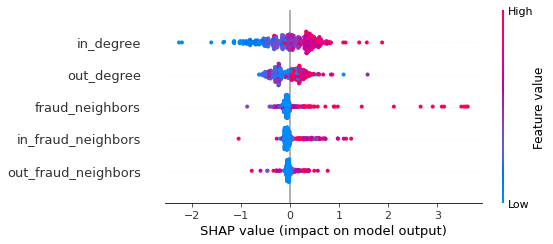

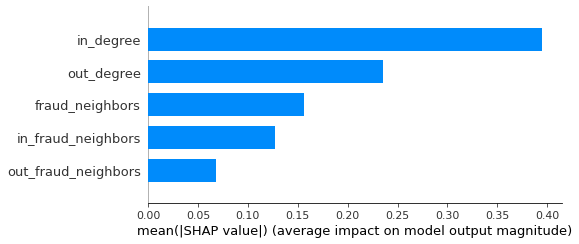

<Figure size 10800x28800 with 0 Axes>

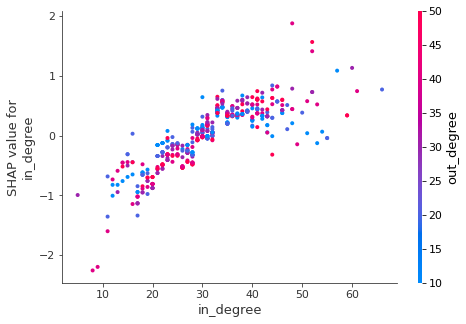

<Figure size 10800x28800 with 0 Axes>

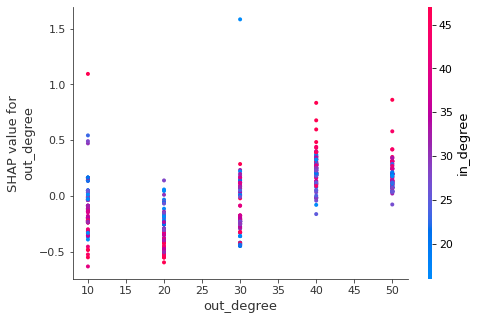

<Figure size 10800x28800 with 0 Axes>

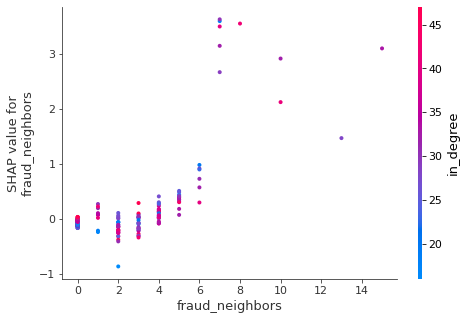

<Figure size 10800x28800 with 0 Axes>

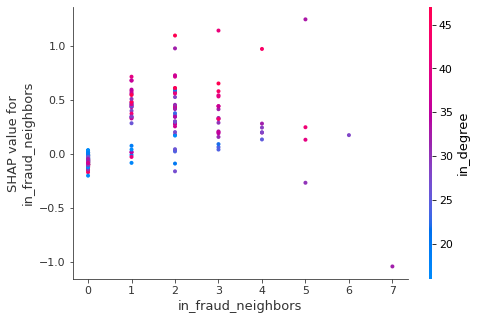

<Figure size 10800x28800 with 0 Axes>

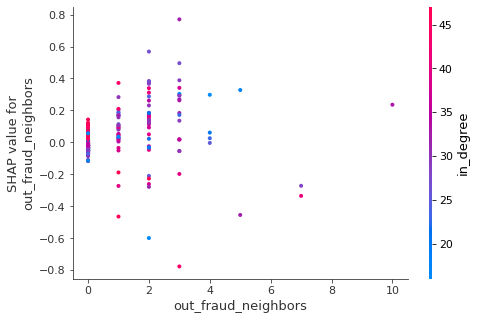

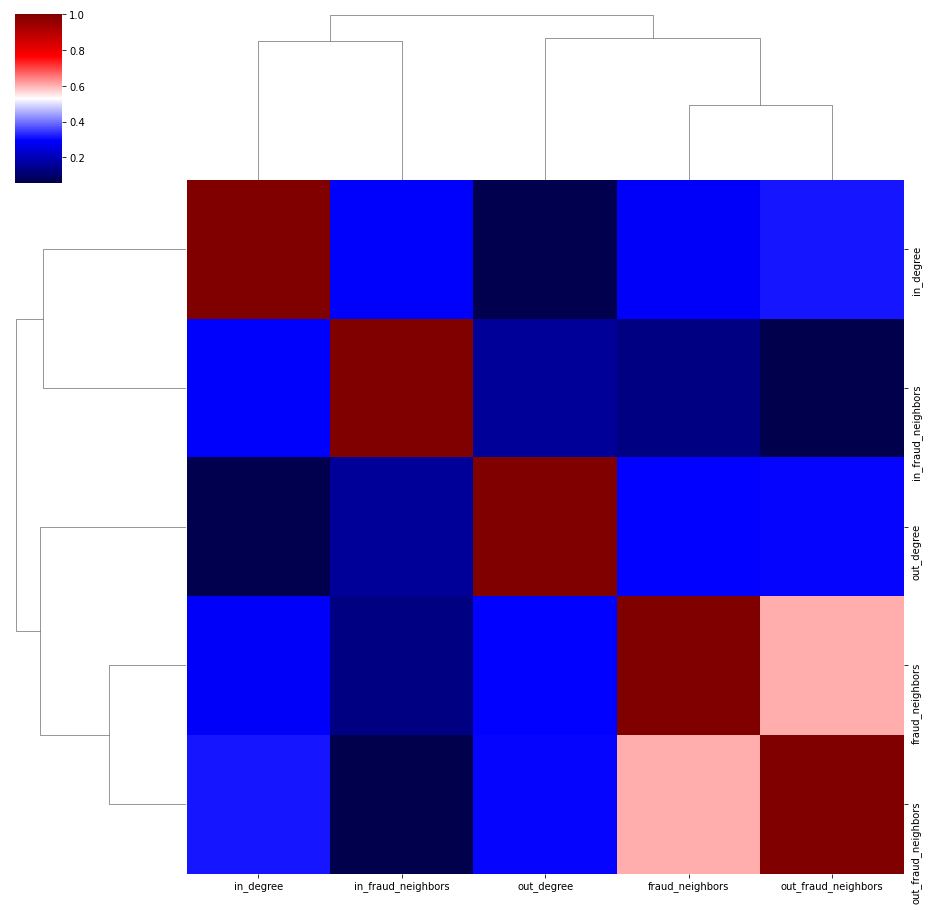

In [66]:
XTRAIN_without_graph.columns = XTRAIN_without_graph.columns.astype(str)
temp = XTRAIN_without_graph.sample(500)
daml_obj.explain_model(temp,type="training")

# Training with Graph features

In [67]:
daml_obj_graph = DAML()

In [68]:
start_time = time.time()

final_eval_rankings_graph,k_fold_results_graph = daml_obj_graph.fit(train_x=XTRAIN_with_graph,train_y=YTRAIN_with_graph,val_x=XTEST_with_graph,val_y=YTEST_with_graph,criteria="f1",folds=7)

print("--- %s seconds ---" % (time.time() - start_time))


[I 2022-10-07 01:03:29,705] A new study created in memory with name: no-name-30ba99b0-1743-4441-b5c1-0ada6e67e031


Threshold value  9223372036854775807
Mode of execution : performance
Tuning Type : default
Criteria of optimization : f1
Number of folds being used : 7
Models being run : ['xgboost', 'lightgbm', 'knn', 'catboost', 'extratrees']
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10
[01:03:29] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.
Fixed parameter 'learning_rate' with value 0.3 is out of range for distribution UniformDistribution(high=0.2, low=0.001).
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:31,334] Trial 0 finished with value: 0.8954545454545454 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.11728219600856332, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 1, 'gamma': 0, 'objective': 'binary:logistic', 'colsample_bytree

[[12615    12]
 [   34   197]]
[01:03:31] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:50,613] Trial 1 finished with value: 0.8285163776493256 and parameters: {'n_estimators': 544, 'max_depth': 14, 'learning_rate': 0.08945057503705887, 'reg_alpha': 2.791517549953162, 'reg_lambda': 3.264821271182961, 'min_child_weight': 1.8627041607861923, 'gamma': 2.8621543814655666, 'objective': 'binary:logistic', 'colsample_bytree': 0.8045888621841705, 'colsample_bynode': 0.4060119336281428, 'colsample_bylevel': 0.40079837365932847, 'subsample': 0.6925468300026285, 'booster': 'gbtree', 'tree_method': 'approx', 'scale_pos_weight': 12.107098052945652}. Best is trial 0 with value: 0.8954545454545454.


[[12554    73]
 [   16   215]]
[01:03:50] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:51,859] Trial 2 finished with value: 0.7324414715719064 and parameters: {'n_estimators': 210, 'max_depth': 17, 'learning_rate': 0.02570055033111634, 'reg_alpha': 3.776239032054653, 'reg_lambda': 1.4790603283721797, 'min_child_weight': 3.882661654666651, 'gamma': 4.909460410723047, 'objective': 'reg:logistic', 'colsample_bytree': 0.3432565572322477, 'colsample_bynode': 0.7973972504029541, 'colsample_bylevel': 0.7266752848323019, 'subsample': 0.8175740212523016, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 10.251089192454824}. Best is trial 0 with value: 0.8954545454545454.


[[12479   148]
 [   12   219]]
[01:03:51] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:52,479] Trial 3 finished with value: 0.322429906542056 and parameters: {'n_estimators': 183, 'max_depth': 5, 'learning_rate': 0.19374482663799364, 'reg_alpha': 2.8287813006766447, 'reg_lambda': 1.2699878898458639, 'min_child_weight': 3.048433457689937, 'gamma': 1.7725917598328094, 'objective': 'binary:logistic', 'colsample_bytree': 0.9047036335672075, 'colsample_bynode': 0.3928569545263212, 'colsample_bylevel': 0.12775157680705188, 'subsample': 0.5425522303510995, 'booster': 'gblinear', 'tree_method': 'approx', 'scale_pos_weight': 8.281242459986945}. Best is trial 0 with value: 0.8954545454545454.


[[12499   128]
 [  162    69]]
[01:03:52] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:55,084] Trial 4 finished with value: 0.3176178660049628 and parameters: {'n_estimators': 829, 'max_depth': 18, 'learning_rate': 0.09733627676787855, 'reg_alpha': 3.6863448459550456, 'reg_lambda': 4.29301528241812, 'min_child_weight': 0.9520100842082935, 'gamma': 1.348906175207849, 'objective': 'reg:logistic', 'colsample_bytree': 0.143569360584424, 'colsample_bynode': 0.9741650683254024, 'colsample_bylevel': 0.29982880780921173, 'subsample': 0.8088448473020676, 'booster': 'gblinear', 'tree_method': 'hist', 'scale_pos_weight': 6.4164120349189275}. Best is trial 0 with value: 0.8954545454545454.


[[12519   108]
 [  167    64]]
[01:03:55] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:58,497] Trial 5 finished with value: 0.8585365853658538 and parameters: {'n_estimators': 787, 'max_depth': 10, 'learning_rate': 0.0471593411040212, 'reg_alpha': 2.8851589988625697, 'reg_lambda': 1.1532740237628252, 'min_child_weight': 0.3968188843963105, 'gamma': 2.0439505507468296, 'objective': 'reg:logistic', 'colsample_bytree': 0.9136734342573178, 'colsample_bynode': 0.606783531673015, 'colsample_bylevel': 0.11241912490264286, 'subsample': 0.7369820848651518, 'booster': 'gbtree', 'tree_method': 'hist', 'scale_pos_weight': 0.7963274859724567}. Best is trial 0 with value: 0.8954545454545454.


[[12624     3]
 [   55   176]]
[01:03:58] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:03:59,701] Trial 6 finished with value: 0.3188405797101449 and parameters: {'n_estimators': 373, 'max_depth': 22, 'learning_rate': 0.07290658003657595, 'reg_alpha': 1.4164938197753023, 'reg_lambda': 2.2854317961738335, 'min_child_weight': 3.3207346020472355, 'gamma': 0.529869194735082, 'objective': 'reg:logistic', 'colsample_bytree': 0.2773112950151292, 'colsample_bynode': 0.9083226136171642, 'colsample_bylevel': 0.9551057541234678, 'subsample': 0.8024347872789428, 'booster': 'gblinear', 'tree_method': 'hist', 'scale_pos_weight': 7.188937446022194}. Best is trial 0 with value: 0.8954545454545454.


[[12510   117]
 [  165    66]]
[01:03:59] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:04:00,242] Trial 7 finished with value: 0.3259259259259259 and parameters: {'n_estimators': 157, 'max_depth': 20, 'learning_rate': 0.12200830597693552, 'reg_alpha': 2.0029880404346105, 'reg_lambda': 3.014514897813871, 'min_child_weight': 1.1174337554312324, 'gamma': 2.2237360937895536, 'objective': 'binary:logistic', 'colsample_bytree': 0.5182313467601344, 'colsample_bynode': 0.3479042284845585, 'colsample_bylevel': 0.4866426693636955, 'subsample': 0.764560702488277, 'booster': 'gblinear', 'tree_method': 'auto', 'scale_pos_weight': 6.439846412291487}. Best is trial 0 with value: 0.8954545454545454.


[[12519   108]
 [  165    66]]
[01:04:00] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:04:02,320] Trial 8 finished with value: 0.1413427561837456 and parameters: {'n_estimators': 667, 'max_depth': 5, 'learning_rate': 0.046726489889924824, 'reg_alpha': 0.4796786528718955, 'reg_lambda': 2.7547193144528572, 'min_child_weight': 0.7745097581890431, 'gamma': 3.3451369193774987, 'objective': 'reg:logistic', 'colsample_bytree': 0.5649982887735474, 'colsample_bynode': 0.6094736415092686, 'colsample_bylevel': 0.26950839205599375, 'subsample': 0.8379766200483846, 'booster': 'gblinear', 'tree_method': 'approx', 'scale_pos_weight': 1.2579138003822288}. Best is trial 0 with value: 0.8954545454545454.


[[12595    32]
 [  211    20]]
[01:04:02] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "scale_neg_weight", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:04:02,803] Trial 9 finished with value: 0.3568464730290456 and parameters: {'n_estimators': 121, 'max_depth': 3, 'learning_rate': 0.17028474601382065, 'reg_alpha': 3.619024064740191, 'reg_lambda': 4.7671313841361105, 'min_child_weight': 0.707102162031496, 'gamma': 3.4376052941942032, 'objective': 'binary:logistic', 'colsample_bytree': 0.30876600538299953, 'colsample_bynode': 0.7969602197549387, 'colsample_bylevel': 0.13811518768076475, 'subsample': 0.9983558021336336, 'booster': 'gblinear', 'tree_method': 'approx', 'scale_pos_weight': 14.254816098092984}. Best is trial 0 with value: 0.8954545454545454.


[[12462   165]
 [  145    86]]
[01:04:02] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
[I 2022-10-07 01:04:12,110] Trial 10 finished with value: 0.8736616702355461 and parameters: {'n_estimators': 405, 'max_depth': 10, 'learning_rate': 0.13142118586684254, 'reg_alpha': 0.14776002772619873, 'reg_lambda': 0.0555562515212884, 'min_child_weight': 2.0395224018611477, 'gamma': 0.02276968395913761, 'objective': 'binary:logistic', 'colsample_bytree': 0.6869058638394984, 'colsample_bynode': 0.11511924787937694, 'colsample_bylevel': 0.9413160037699813, 'subsample': 0.991690408807935, 'booster': 'gbtree', 'tree_method': 'exact', 'scale_pos_weight': 19.563416794344008}. Best is trial 0 with value: 0.8954545454545454.
[I 2022-10-07 01:04:12,118] A new study created in memory w

[[12595    32]
 [   27   204]]
 Early stopping the HPO as Patience is breached 
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.
[I 2022-10-07 01:04:12,529] Trial 0 finished with value: 0.8160377358490566 and parameters: {'n_estimators': 100, 'num_leaves': 31, 'max_depth': 10, 'max_bin': 255, 'min_data_in_leaf': 20, 'min_data_in_bin': 3, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.


[[12607    20]
 [   58   173]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1.7521103125307624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7521103125307624
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=227, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=227
[LightGBM] [Warning] lambda_l2 is set=3.843657002156953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.843657002156953


[I 2022-10-07 01:04:13,292] Trial 1 finished with value: 0.611764705882353 and parameters: {'n_estimators': 277, 'num_leaves': 189, 'max_depth': 167, 'max_bin': 59, 'min_data_in_leaf': 227, 'min_data_in_bin': 127, 'lambda_l1': 1.7521103125307624, 'lambda_l2': 3.843657002156953, 'learning_rate': 0.02255727682873774, 'feature_fraction': 1.0, 'bagging_fraction': 0.5, 'is_unbalanced': False}. Best is trial 0 with value: 0.8160377358490566.


[[12622     5]
 [  127   104]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=4.7650342966677375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7650342966677375
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] lambda_l2 is set=3.6968245633483865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6968245633483865


[I 2022-10-07 01:04:13,873] Trial 2 finished with value: 0.7238605898123324 and parameters: {'n_estimators': 269, 'num_leaves': 205, 'max_depth': 30, 'max_bin': 234, 'min_data_in_leaf': 55, 'min_data_in_bin': 87, 'lambda_l1': 4.7650342966677375, 'lambda_l2': 3.6968245633483865, 'learning_rate': 0.049975621597980406, 'feature_fraction': 0.75, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 0 with value: 0.8160377358490566.


[[12620     7]
 [   96   135]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=3.487368040391932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.487368040391932
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=4.562392083933861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.562392083933861


[I 2022-10-07 01:04:14,503] Trial 3 finished with value: 0.8076009501187649 and parameters: {'n_estimators': 286, 'num_leaves': 196, 'max_depth': 181, 'max_bin': 237, 'min_data_in_leaf': 16, 'min_data_in_bin': 210, 'lambda_l1': 3.487368040391932, 'lambda_l2': 4.562392083933861, 'learning_rate': 0.19037806955044076, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 0 with value: 0.8160377358490566.


[[12607    20]
 [   61   170]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=3.545318555429375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.545318555429375
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] lambda_l2 is set=2.086850888335852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.086850888335852


[I 2022-10-07 01:04:14,799] Trial 4 finished with value: 0.6042780748663101 and parameters: {'n_estimators': 108, 'num_leaves': 226, 'max_depth': 125, 'max_bin': 88, 'min_data_in_leaf': 156, 'min_data_in_bin': 7, 'lambda_l1': 3.545318555429375, 'lambda_l2': 2.086850888335852, 'learning_rate': 0.19609254384053726, 'feature_fraction': 0.5, 'bagging_fraction': 0.75, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.
[I 2022-10-07 01:04:14,978] Trial 5 finished with value: 0.7263681592039801 and parameters: {'n_estimators': 57, 'num_leaves': 238, 'max_depth': 200, 'max_bin': 158, 'min_data_in_leaf': 224, 'min_data_in_bin': 67, 'lambda_l1': 4.584355883993309, 'lambda_l2': 3.4559376446647687, 'learning_rate': 0.15363991221594045, 'feature_fraction': 0.75, 'bagging_fraction': 0.75, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.


[[12597    30]
 [  118   113]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=4.584355883993309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.584355883993309
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224
[LightGBM] [Warning] lambda_l2 is set=3.4559376446647687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4559376446647687
[[12602    25]
 [   85   146]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.041781856273770956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.041781856273770956
[LightGBM] [Warning] bagging_fraction is se

[I 2022-10-07 01:04:15,673] Trial 6 finished with value: 0.700507614213198 and parameters: {'n_estimators': 212, 'num_leaves': 191, 'max_depth': 88, 'max_bin': 138, 'min_data_in_leaf': 250, 'min_data_in_bin': 231, 'lambda_l1': 0.041781856273770956, 'lambda_l2': 1.2638619632040349, 'learning_rate': 0.10751776503676465, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'is_unbalanced': False}. Best is trial 0 with value: 0.8160377358490566.
[I 2022-10-07 01:04:15,828] Trial 7 finished with value: 0.7016574585635358 and parameters: {'n_estimators': 37, 'num_leaves': 14, 'max_depth': 117, 'max_bin': 130, 'min_data_in_leaf': 187, 'min_data_in_bin': 113, 'lambda_l1': 0.2973498731013585, 'lambda_l2': 4.228669835710502, 'learning_rate': 0.17511526095026295, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.


[[12602    25]
 [   93   138]]
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.2973498731013585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2973498731013585
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] lambda_l2 is set=4.228669835710502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.228669835710502
[[12623     4]
 [  104   127]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=4.72034865017661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.72034865017661
[LightGBM] [Warning] bagging_fraction is set=1.0, sub

[I 2022-10-07 01:04:16,012] Trial 8 finished with value: 0.6648936170212766 and parameters: {'n_estimators': 75, 'num_leaves': 3, 'max_depth': 8, 'max_bin': 121, 'min_data_in_leaf': 155, 'min_data_in_bin': 143, 'lambda_l1': 4.72034865017661, 'lambda_l2': 1.9444036607526423, 'learning_rate': 0.11335965207578702, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.
[I 2022-10-07 01:04:16,172] Trial 9 finished with value: 0.5047318611987381 and parameters: {'n_estimators': 38, 'num_leaves': 23, 'max_depth': 10, 'max_bin': 253, 'min_data_in_leaf': 43, 'min_data_in_bin': 180, 'lambda_l1': 1.796097466150552, 'lambda_l2': 1.3870121916169431, 'learning_rate': 0.12133335533657039, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.


[[12607    20]
 [  106   125]]
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.796097466150552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.796097466150552
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] lambda_l2 is set=1.3870121916169431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3870121916169431
[[12621     6]
 [  151    80]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=1.2081252067377903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2081252067377903
[LightGBM] [Warning] bagging_fraction is set=1.0, sub

[I 2022-10-07 01:04:16,669] Trial 10 finished with value: 0.749379652605459 and parameters: {'n_estimators': 157, 'num_leaves': 83, 'max_depth': 65, 'max_bin': 196, 'min_data_in_leaf': 101, 'min_data_in_bin': 13, 'lambda_l1': 1.2081252067377903, 'lambda_l2': 0.08271425790905375, 'learning_rate': 0.0691963308709801, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'is_unbalanced': True}. Best is trial 0 with value: 0.8160377358490566.
[I 2022-10-07 01:04:16,676] A new study created in memory with name: no-name-10a0ec1b-b8e8-4ba6-a481-80dac1ad1b9b


[[12606    21]
 [   80   151]]
 Early stopping the HPO as Patience is breached 
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10


enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.
[I 2022-10-07 01:04:17,485] Trial 0 finished with value: 0.3767441860465116 and parameters: {'n_neighbors': 3, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.3767441860465116.


[[12509   118]
 [  150    81]]


[I 2022-10-07 01:04:18,284] Trial 1 finished with value: 0.3033707865168539 and parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.3767441860465116.


[[12556    71]
 [  177    54]]


[I 2022-10-07 01:04:19,304] Trial 2 finished with value: 0.10606060606060606 and parameters: {'n_neighbors': 22, 'algorithm': 'auto'}. Best is trial 0 with value: 0.3767441860465116.


[[12608    19]
 [  217    14]]


[I 2022-10-07 01:04:20,150] Trial 3 finished with value: 0.20202020202020202 and parameters: {'n_neighbors': 10, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.3767441860465116.


[[12591    36]
 [  201    30]]


[I 2022-10-07 01:04:20,943] Trial 4 finished with value: 0.3033707865168539 and parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.3767441860465116.


[[12556    71]
 [  177    54]]


[I 2022-10-07 01:04:21,773] Trial 5 finished with value: 0.25903614457831325 and parameters: {'n_neighbors': 9, 'algorithm': 'auto'}. Best is trial 0 with value: 0.3767441860465116.


[[12569    58]
 [  188    43]]


[I 2022-10-07 01:04:22,597] Trial 6 finished with value: 0.22727272727272727 and parameters: {'n_neighbors': 8, 'algorithm': 'auto'}. Best is trial 0 with value: 0.3767441860465116.


[[12585    42]
 [  196    35]]


[I 2022-10-07 01:04:23,492] Trial 7 finished with value: 0.18556701030927833 and parameters: {'n_neighbors': 15, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.3767441860465116.


[[12594    33]
 [  204    27]]


[I 2022-10-07 01:04:24,305] Trial 8 finished with value: 0.27350427350427353 and parameters: {'n_neighbors': 7, 'algorithm': 'auto'}. Best is trial 0 with value: 0.3767441860465116.


[[12555    72]
 [  183    48]]


[I 2022-10-07 01:04:25,263] Trial 9 finished with value: 0.16083916083916083 and parameters: {'n_neighbors': 19, 'algorithm': 'auto'}. Best is trial 0 with value: 0.3767441860465116.


[[12595    32]
 [  208    23]]


[I 2022-10-07 01:04:26,173] Trial 10 finished with value: 0.14652014652014653 and parameters: {'n_neighbors': 14, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.3767441860465116.
[I 2022-10-07 01:04:26,177] A new study created in memory with name: no-name-734f0bcd-f787-4d59-99a3-b98e1b96a438


[[12605    22]
 [  211    20]]
 Early stopping the HPO as Patience is breached 
pruner type within optuna  median
Using early stopping for Hyperparameter tuning with Patience level: 10


enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
create_trial is experimental (supported from v2.0.0). The interface can change in the future.
add_trial is experimental (supported from v2.0.0). The interface can change in the future.


0:	learn: 0.6077050	total: 6.58ms	remaining: 6.58s
1:	learn: 0.5355655	total: 12.5ms	remaining: 6.26s
2:	learn: 0.4599988	total: 18.7ms	remaining: 6.22s
3:	learn: 0.4075474	total: 24.8ms	remaining: 6.18s
4:	learn: 0.3638069	total: 31.1ms	remaining: 6.19s
5:	learn: 0.2931625	total: 37.4ms	remaining: 6.2s
6:	learn: 0.2530692	total: 43.7ms	remaining: 6.2s
7:	learn: 0.2168371	total: 50.2ms	remaining: 6.22s
8:	learn: 0.1766659	total: 56.7ms	remaining: 6.24s
9:	learn: 0.1596584	total: 63.3ms	remaining: 6.27s
10:	learn: 0.1385296	total: 69.4ms	remaining: 6.24s
11:	learn: 0.1144140	total: 75.7ms	remaining: 6.23s
12:	learn: 0.1052026	total: 82.1ms	remaining: 6.23s
13:	learn: 0.0868340	total: 88.3ms	remaining: 6.22s
14:	learn: 0.0737590	total: 94.6ms	remaining: 6.21s
15:	learn: 0.0619381	total: 101ms	remaining: 6.21s
16:	learn: 0.0518907	total: 107ms	remaining: 6.18s
17:	learn: 0.0444463	total: 113ms	remaining: 6.17s
18:	learn: 0.0380604	total: 120ms	remaining: 6.17s
19:	learn: 0.0330364	total: 

[I 2022-10-07 01:04:32,808] Trial 0 finished with value: 0.8898876404494381 and parameters: {'scale_pos_weight': 1}. Best is trial 0 with value: 0.8898876404494381.


[[12611    16]
 [   33   198]]
0:	learn: 0.5703710	total: 6.86ms	remaining: 6.86s
1:	learn: 0.4671688	total: 13.6ms	remaining: 6.76s
2:	learn: 0.3899740	total: 19.6ms	remaining: 6.51s
3:	learn: 0.3239642	total: 25.8ms	remaining: 6.41s
4:	learn: 0.2668346	total: 32.3ms	remaining: 6.43s
5:	learn: 0.2255316	total: 38.8ms	remaining: 6.43s
6:	learn: 0.1867246	total: 44.9ms	remaining: 6.37s
7:	learn: 0.1584520	total: 51.2ms	remaining: 6.34s
8:	learn: 0.1334853	total: 57.4ms	remaining: 6.32s
9:	learn: 0.1135622	total: 63.7ms	remaining: 6.31s
10:	learn: 0.0989601	total: 69.9ms	remaining: 6.29s
11:	learn: 0.0856559	total: 76.4ms	remaining: 6.29s
12:	learn: 0.0750123	total: 82.1ms	remaining: 6.23s
13:	learn: 0.0663808	total: 88.1ms	remaining: 6.21s
14:	learn: 0.0626549	total: 94.4ms	remaining: 6.2s
15:	learn: 0.0566483	total: 101ms	remaining: 6.19s
16:	learn: 0.0520855	total: 107ms	remaining: 6.17s
17:	learn: 0.0497294	total: 113ms	remaining: 6.16s
18:	learn: 0.0456345	total: 119ms	remaining: 6.

[I 2022-10-07 01:04:39,622] Trial 1 finished with value: 0.8470588235294116 and parameters: {'scale_pos_weight': 7.786200947593535}. Best is trial 0 with value: 0.8898876404494381.


[[12564    63]
 [   15   216]]
0:	learn: 0.5678851	total: 6.47ms	remaining: 6.47s
1:	learn: 0.4633909	total: 13ms	remaining: 6.48s
2:	learn: 0.3836174	total: 19.1ms	remaining: 6.33s
3:	learn: 0.3141168	total: 25.2ms	remaining: 6.28s
4:	learn: 0.2597961	total: 32ms	remaining: 6.38s
5:	learn: 0.2178744	total: 38.6ms	remaining: 6.39s
6:	learn: 0.1784679	total: 44.5ms	remaining: 6.32s
7:	learn: 0.1514063	total: 51ms	remaining: 6.32s
8:	learn: 0.1272811	total: 57.3ms	remaining: 6.31s
9:	learn: 0.1152237	total: 63.9ms	remaining: 6.32s
10:	learn: 0.1043375	total: 70.5ms	remaining: 6.33s
11:	learn: 0.0888667	total: 76.8ms	remaining: 6.32s
12:	learn: 0.0771078	total: 83ms	remaining: 6.3s
13:	learn: 0.0672735	total: 89.1ms	remaining: 6.27s
14:	learn: 0.0596294	total: 95.3ms	remaining: 6.26s
15:	learn: 0.0532727	total: 102ms	remaining: 6.25s
16:	learn: 0.0486348	total: 108ms	remaining: 6.25s
17:	learn: 0.0448585	total: 114ms	remaining: 6.23s
18:	learn: 0.0415940	total: 120ms	remaining: 6.22s
19:	

[I 2022-10-07 01:04:46,427] Trial 2 finished with value: 0.8450704225352113 and parameters: {'scale_pos_weight': 5.313508202241277}. Best is trial 0 with value: 0.8898876404494381.


[[12571    56]
 [   21   210]]
0:	learn: 0.5768713	total: 5.99ms	remaining: 5.99s
1:	learn: 0.4752097	total: 12.2ms	remaining: 6.09s
2:	learn: 0.3995776	total: 18.6ms	remaining: 6.18s
3:	learn: 0.3310791	total: 24.8ms	remaining: 6.17s
4:	learn: 0.2782521	total: 31ms	remaining: 6.17s
5:	learn: 0.2373750	total: 37.6ms	remaining: 6.23s
6:	learn: 0.1976521	total: 43.8ms	remaining: 6.21s
7:	learn: 0.1688263	total: 50.2ms	remaining: 6.22s
8:	learn: 0.1430659	total: 56.3ms	remaining: 6.2s
9:	learn: 0.1251708	total: 62.7ms	remaining: 6.2s
10:	learn: 0.1100846	total: 68.6ms	remaining: 6.17s
11:	learn: 0.0956017	total: 74.7ms	remaining: 6.15s
12:	learn: 0.0844756	total: 81ms	remaining: 6.15s
13:	learn: 0.0759256	total: 87ms	remaining: 6.13s
14:	learn: 0.0713715	total: 93.4ms	remaining: 6.13s
15:	learn: 0.0644964	total: 99.7ms	remaining: 6.13s
16:	learn: 0.0594276	total: 106ms	remaining: 6.11s
17:	learn: 0.0565431	total: 112ms	remaining: 6.11s
18:	learn: 0.0526427	total: 118ms	remaining: 6.08s
19

[I 2022-10-07 01:04:53,277] Trial 3 finished with value: 0.823076923076923 and parameters: {'scale_pos_weight': 10.63801582250143}. Best is trial 0 with value: 0.8898876404494381.


[[12552    75]
 [   17   214]]
0:	learn: 0.6097907	total: 6.72ms	remaining: 6.71s
1:	learn: 0.4958537	total: 12.9ms	remaining: 6.43s
2:	learn: 0.4095192	total: 18.9ms	remaining: 6.27s
3:	learn: 0.3366324	total: 25.4ms	remaining: 6.32s
4:	learn: 0.2772263	total: 31.8ms	remaining: 6.32s
5:	learn: 0.2306964	total: 38ms	remaining: 6.3s
6:	learn: 0.1896037	total: 43.9ms	remaining: 6.23s
7:	learn: 0.1599672	total: 50.2ms	remaining: 6.23s
8:	learn: 0.1337262	total: 56.3ms	remaining: 6.2s
9:	learn: 0.1204373	total: 62.7ms	remaining: 6.21s
10:	learn: 0.1085247	total: 68.7ms	remaining: 6.17s
11:	learn: 0.0918640	total: 75ms	remaining: 6.17s
12:	learn: 0.0792274	total: 81.3ms	remaining: 6.18s
13:	learn: 0.0686643	total: 87.2ms	remaining: 6.14s
14:	learn: 0.0604976	total: 93.5ms	remaining: 6.14s
15:	learn: 0.0537175	total: 99.7ms	remaining: 6.13s
16:	learn: 0.0482875	total: 106ms	remaining: 6.12s
17:	learn: 0.0439314	total: 112ms	remaining: 6.12s
18:	learn: 0.0403761	total: 118ms	remaining: 6.12s


[I 2022-10-07 01:05:00,078] Trial 4 finished with value: 0.8571428571428571 and parameters: {'scale_pos_weight': 4.699660947928361}. Best is trial 0 with value: 0.8898876404494381.


[[12578    49]
 [   21   210]]
0:	learn: 0.6089067	total: 6.41ms	remaining: 6.41s
1:	learn: 0.5379336	total: 12.4ms	remaining: 6.2s
2:	learn: 0.4629257	total: 18.5ms	remaining: 6.15s
3:	learn: 0.4111726	total: 24.7ms	remaining: 6.15s
4:	learn: 0.3656521	total: 31ms	remaining: 6.17s
5:	learn: 0.2949225	total: 37.3ms	remaining: 6.17s
6:	learn: 0.2551707	total: 43.4ms	remaining: 6.16s
7:	learn: 0.2145086	total: 49.9ms	remaining: 6.18s
8:	learn: 0.1727542	total: 56.1ms	remaining: 6.17s
9:	learn: 0.1527805	total: 62.6ms	remaining: 6.2s
10:	learn: 0.1331197	total: 68.6ms	remaining: 6.17s
11:	learn: 0.1101967	total: 75.3ms	remaining: 6.2s
12:	learn: 0.1017170	total: 81.6ms	remaining: 6.19s
13:	learn: 0.0837301	total: 88ms	remaining: 6.19s
14:	learn: 0.0712868	total: 94.2ms	remaining: 6.18s
15:	learn: 0.0600996	total: 101ms	remaining: 6.19s
16:	learn: 0.0509397	total: 107ms	remaining: 6.18s
17:	learn: 0.0438145	total: 113ms	remaining: 6.17s
18:	learn: 0.0378949	total: 119ms	remaining: 6.16s
19

[I 2022-10-07 01:05:06,716] Trial 5 finished with value: 0.8828828828828829 and parameters: {'scale_pos_weight': 1.10770072548181}. Best is trial 0 with value: 0.8898876404494381.


[[12610    17]
 [   35   196]]
0:	learn: 0.6096209	total: 6.83ms	remaining: 6.82s
1:	learn: 0.5193285	total: 12.7ms	remaining: 6.33s
2:	learn: 0.4274254	total: 19ms	remaining: 6.31s
3:	learn: 0.3736659	total: 25.2ms	remaining: 6.27s
4:	learn: 0.3092084	total: 31.5ms	remaining: 6.27s
5:	learn: 0.2643826	total: 37.7ms	remaining: 6.25s
6:	learn: 0.2211999	total: 43.9ms	remaining: 6.22s
7:	learn: 0.1906483	total: 50.3ms	remaining: 6.24s
8:	learn: 0.1597908	total: 56.6ms	remaining: 6.24s
9:	learn: 0.1352445	total: 63.2ms	remaining: 6.26s
10:	learn: 0.1157003	total: 69.7ms	remaining: 6.26s
11:	learn: 0.0973801	total: 76.1ms	remaining: 6.26s
12:	learn: 0.0825030	total: 82.4ms	remaining: 6.26s
13:	learn: 0.0703347	total: 88.7ms	remaining: 6.24s
14:	learn: 0.0598163	total: 94.9ms	remaining: 6.23s
15:	learn: 0.0511574	total: 101ms	remaining: 6.24s
16:	learn: 0.0443612	total: 107ms	remaining: 6.2s
17:	learn: 0.0369367	total: 114ms	remaining: 6.2s
18:	learn: 0.0325901	total: 120ms	remaining: 6.19s

[I 2022-10-07 01:05:12,844] Trial 6 finished with value: 0.8486352357320099 and parameters: {'scale_pos_weight': 0.22416380663097613}. Best is trial 0 with value: 0.8898876404494381.


0:	learn: 0.5711197	total: 6.5ms	remaining: 6.49s
1:	learn: 0.4672312	total: 12.7ms	remaining: 6.33s
2:	learn: 0.3924044	total: 18.9ms	remaining: 6.29s
3:	learn: 0.3247248	total: 25ms	remaining: 6.22s
4:	learn: 0.2736035	total: 31.3ms	remaining: 6.22s
5:	learn: 0.2332187	total: 37.8ms	remaining: 6.27s
6:	learn: 0.1966324	total: 43.9ms	remaining: 6.23s
7:	learn: 0.1680290	total: 50.2ms	remaining: 6.23s
8:	learn: 0.1424291	total: 56.3ms	remaining: 6.2s
9:	learn: 0.1249048	total: 62.6ms	remaining: 6.2s
10:	learn: 0.1098791	total: 68.8ms	remaining: 6.19s
11:	learn: 0.0954321	total: 75.1ms	remaining: 6.18s
12:	learn: 0.0843174	total: 81.4ms	remaining: 6.18s
13:	learn: 0.0760105	total: 87.5ms	remaining: 6.16s
14:	learn: 0.0714141	total: 93.7ms	remaining: 6.15s
15:	learn: 0.0645204	total: 100ms	remaining: 6.15s
16:	learn: 0.0594461	total: 106ms	remaining: 6.13s
17:	learn: 0.0565334	total: 112ms	remaining: 6.12s
18:	learn: 0.0526305	total: 118ms	remaining: 6.1s
19:	learn: 0.0496279	total: 124m

[I 2022-10-07 01:05:19,637] Trial 7 finished with value: 0.8185328185328185 and parameters: {'scale_pos_weight': 10.590103747058599}. Best is trial 0 with value: 0.8898876404494381.


[[12552    75]
 [   19   212]]
0:	learn: 0.5680128	total: 6.36ms	remaining: 6.35s
1:	learn: 0.4636192	total: 12.5ms	remaining: 6.25s
2:	learn: 0.3839224	total: 18.5ms	remaining: 6.14s
3:	learn: 0.3144849	total: 24.8ms	remaining: 6.19s
4:	learn: 0.2608387	total: 31.7ms	remaining: 6.3s
5:	learn: 0.2183781	total: 38.3ms	remaining: 6.35s
6:	learn: 0.1789491	total: 44.3ms	remaining: 6.28s
7:	learn: 0.1518756	total: 50.8ms	remaining: 6.3s
8:	learn: 0.1277257	total: 57ms	remaining: 6.28s
9:	learn: 0.1156754	total: 63.5ms	remaining: 6.29s
10:	learn: 0.1047846	total: 69.8ms	remaining: 6.28s
11:	learn: 0.0892816	total: 76.1ms	remaining: 6.26s
12:	learn: 0.0774948	total: 82.2ms	remaining: 6.24s
13:	learn: 0.0676368	total: 88.1ms	remaining: 6.21s
14:	learn: 0.0599706	total: 94.2ms	remaining: 6.18s
15:	learn: 0.0535937	total: 101ms	remaining: 6.18s
16:	learn: 0.0489437	total: 107ms	remaining: 6.18s
17:	learn: 0.0451548	total: 113ms	remaining: 6.16s
18:	learn: 0.0418823	total: 119ms	remaining: 6.14s

[I 2022-10-07 01:05:26,452] Trial 8 finished with value: 0.8346774193548387 and parameters: {'scale_pos_weight': 5.429462784824938}. Best is trial 0 with value: 0.8898876404494381.


[[12569    58]
 [   24   207]]
0:	learn: 0.5698888	total: 6.12ms	remaining: 6.12s
1:	learn: 0.4670831	total: 12.1ms	remaining: 6.05s
2:	learn: 0.3895498	total: 18ms	remaining: 6s
3:	learn: 0.3232514	total: 24.4ms	remaining: 6.08s
4:	learn: 0.2648512	total: 30.9ms	remaining: 6.16s
5:	learn: 0.2236278	total: 37.4ms	remaining: 6.19s
6:	learn: 0.1876667	total: 43.2ms	remaining: 6.13s
7:	learn: 0.1592043	total: 49.4ms	remaining: 6.13s
8:	learn: 0.1340008	total: 55.5ms	remaining: 6.11s
9:	learn: 0.1132234	total: 61.3ms	remaining: 6.07s
10:	learn: 0.0986352	total: 67.4ms	remaining: 6.06s
11:	learn: 0.0852941	total: 73.5ms	remaining: 6.05s
12:	learn: 0.0747963	total: 79.8ms	remaining: 6.05s
13:	learn: 0.0658289	total: 85.6ms	remaining: 6.03s
14:	learn: 0.0591717	total: 91.6ms	remaining: 6.02s
15:	learn: 0.0539746	total: 97.8ms	remaining: 6.01s
16:	learn: 0.0500607	total: 104ms	remaining: 6.02s
17:	learn: 0.0477984	total: 110ms	remaining: 6.02s
18:	learn: 0.0446934	total: 116ms	remaining: 6.01s

[I 2022-10-07 01:05:33,210] Trial 9 finished with value: 0.8425196850393701 and parameters: {'scale_pos_weight': 7.271627456650079}. Best is trial 0 with value: 0.8898876404494381.


[[12564    63]
 [   17   214]]
[01:05:33] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12615    12]
 [   34   197]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12607    20]
 [   58   173]]
[[12509   118]
 [  150    81]]
0:	learn: 0.6077050	total: 6.49ms	remaining: 6.48s
1:	learn: 0.5355655	total: 12.6ms	remaining: 6.28s
2:	learn: 0.4599988	total: 18.6ms	remaining: 6.19s
3:	learn: 0.4075474	total: 24.9ms	remaining: 6.2s
4:	learn: 0.3638069	total: 31.2ms	remaining: 6.21s
5:	learn: 0.2931625	total: 37.6ms	remaining: 6.23s
6:	learn: 0.2530692	total: 43.9ms	remain

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12618     9]
 [   32   199]]
[01:05:43] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12615    12]
 [   41   189]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12596  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12623     4]
 [   30   200]]
[01:05:53] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12624     3]
 [   30   200]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12608  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12622     5]
 [   26   204]]
[01:06:03] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12615    12]
 [   39   191]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12614  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12626     1]
 [   34   196]]
[01:06:13] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12619     8]
 [   40   190]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12610  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12623     4]
 [   39   191]]
[01:06:23] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12616    10]
 [   40   191]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12608  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12624     2]
 [   33   198]]
[01:06:33] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[12614    12]
 [   43   188]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[12612  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[12623     3]
 [   36   195]]
[01:06:43] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_neg_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[9831    6]
 [  29  134]]
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[[9827   10]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


[[9836    1]
 [  21  142]]
--- 203.6266152858734 seconds ---


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


k fold results of  models with graph features evaluated on the holdout test dataset

In [69]:
k_fold_results_graph

,index,Models,average_performance_metric_score,k_fold_number_1,k_fold_number_2,k_fold_number_3,k_fold_number_4,k_fold_number_5,k_fold_number_6,k_fold_number_7
0,0,xgboost,0.888998,0.895455,0.877030,0.923788,0.882217,0.887850,0.884259,0.872390
1,1,lightgbm,0.806370,0.816038,0.765957,0.817102,0.826087,0.818182,0.817102,0.784119
2,2,knn,0.398747,0.376744,0.396985,0.440191,0.408551,0.387991,0.377011,0.403756
3,3,catboost,0.897733,0.889888,0.905405,0.922018,0.907834,0.888372,0.891892,0.878719
4,4,extratrees,0.914627,0.906606,0.921659,0.929385,0.918033,0.898824,0.918794,0.909091


Final trained model with graph features evaluated on the holdout test dataset

In [70]:
final_eval_rankings_graph

,index,Models,Criteria_Metrics,true_negative,false_positive,false_negatve,true_positive,recall,precision,f1,accuracy,log_loss,roc_auc,mcc
0,4,extratrees,0.928105,9836.0,1.0,21.0,142.0,0.871166,0.993007,0.928105,0.9978,0.007036,0.935532,0.929041
1,3,catboost,0.900322,9829.0,8.0,23.0,140.0,0.858896,0.945946,0.900322,0.9969,0.008216,0.929041,0.899831
2,0,xgboost,0.884488,9831.0,6.0,29.0,134.0,0.822086,0.957143,0.884488,0.9965,0.008075,0.910738,0.885355
3,1,lightgbm,0.823129,9827.0,10.0,42.0,121.0,0.742331,0.923664,0.823129,0.9948,0.013924,0.870657,0.825573
4,2,knn,0.447458,9771.0,66.0,97.0,66.0,0.404908,0.500000,0.447458,0.9837,0.209370,0.699099,0.441798


# Getting Preditions With Graph Features

In [71]:
predictions,probabilities = daml_obj.predict(XTEST_with_graph)

X has feature names, but ExtraTreesClassifier was fitted without feature names
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
X has feature names, but ExtraTreesClassifier was fitted without feature names
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


# Explain Model With Graph Features

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
[1007/010653.762940:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[1007/010653.778564:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[1007/010653.982243:INFO:headless_shell.cc(660)] Written to file /tmp/tmp3eyg_xbh/temp.png.
[1007/010654.262148:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[1007/010654.284106:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[1007/010654.482792:INFO:headless_shell.cc(660)] Written to file /tmp/tmpajjstud1/temp.png.


Plotting Beeswarm plot
Plotting Bar plot
Plotting dependency plots


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Model plotting done
Generating Report
model_explanations/dependenceplot_approx_betweenness.png
model_explanations/dependenceplot_conductance_minimization.png
model_explanations/dependenceplot_degree.png
model_explanations/dependenceplot_eigenvector.png
model_explanations/dependenceplot_fraud_closeness.png
model_explanations/dependenceplot_fraud_neighbors.png
model_explanations/dependenceplot_in_degree.png
model_explanations/dependenceplot_in_fraud_neighbors.png
model_explanations/dependenceplot_label_propagation.png
model_explanations/dependenceplot_out_degree.png
model_explanations/dependenceplot_out_fraud_neighbors.png
model_explanations/dependenceplot_pagerank.png
(127, '/bin/sh: latexmk: command not found')
Report Generation Done
Model explained


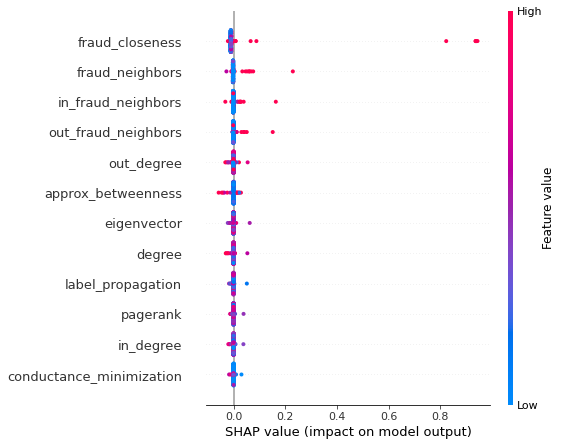

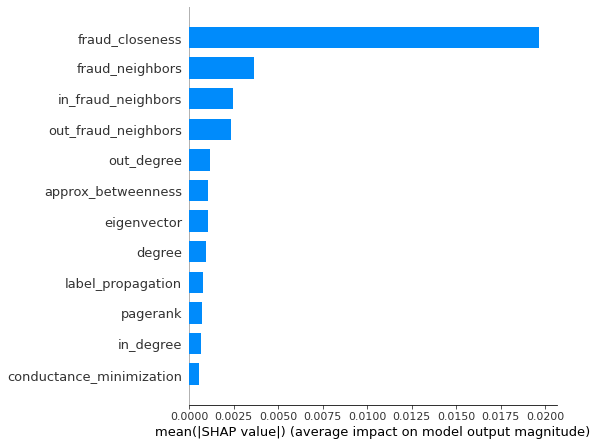

<Figure size 10800x28800 with 0 Axes>

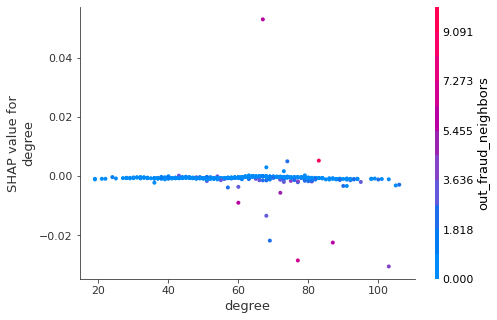

<Figure size 10800x28800 with 0 Axes>

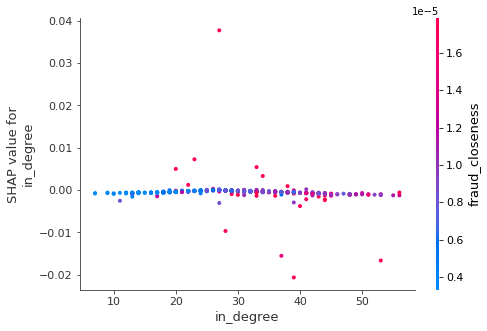

<Figure size 10800x28800 with 0 Axes>

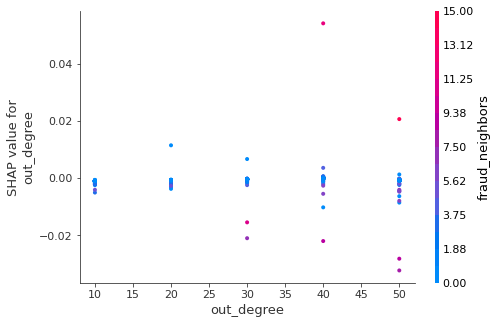

<Figure size 10800x28800 with 0 Axes>

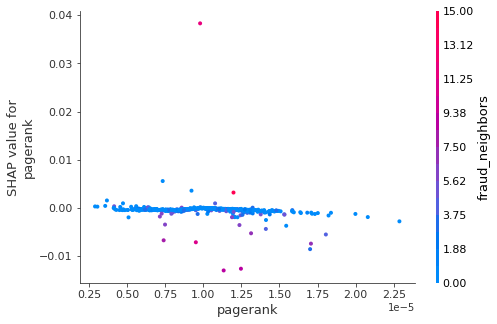

<Figure size 10800x28800 with 0 Axes>

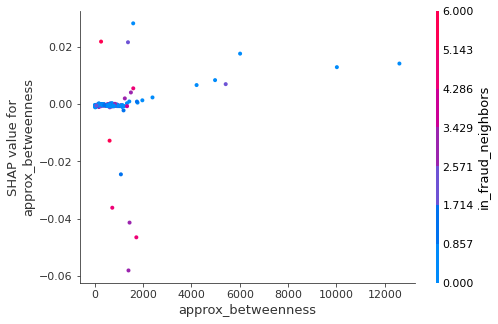

<Figure size 10800x28800 with 0 Axes>

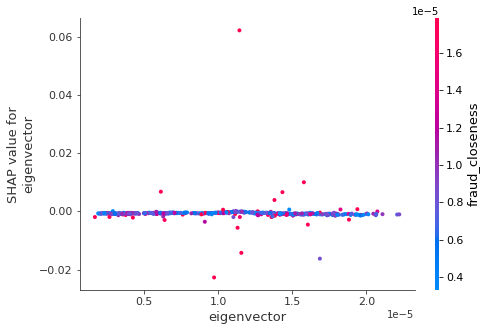

<Figure size 10800x28800 with 0 Axes>

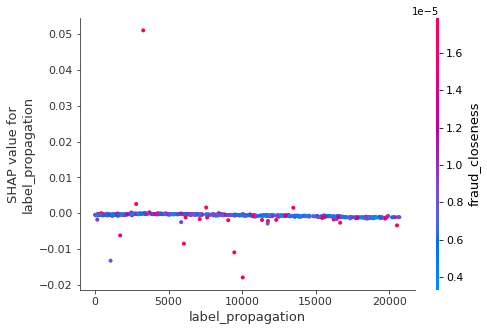

<Figure size 10800x28800 with 0 Axes>

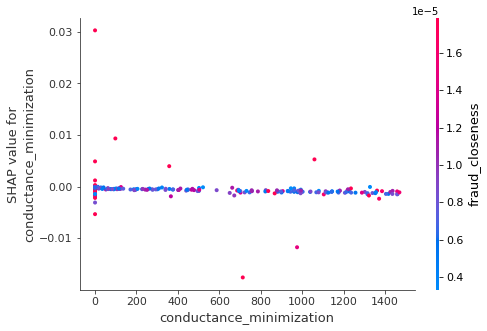

<Figure size 10800x28800 with 0 Axes>

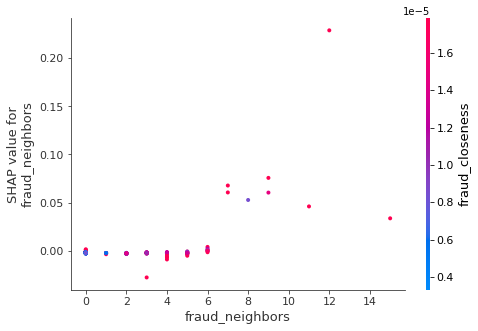

<Figure size 10800x28800 with 0 Axes>

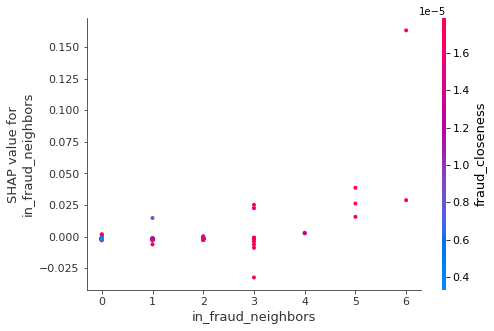

<Figure size 10800x28800 with 0 Axes>

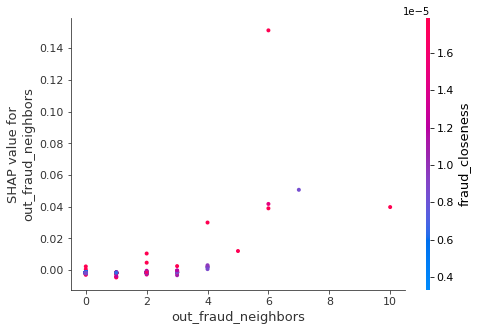

<Figure size 10800x28800 with 0 Axes>

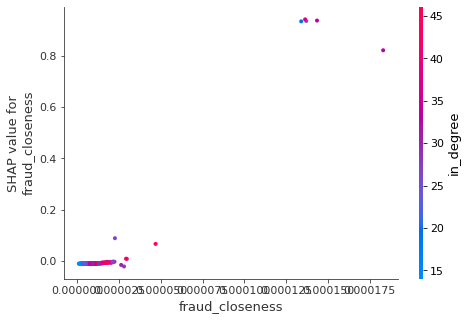

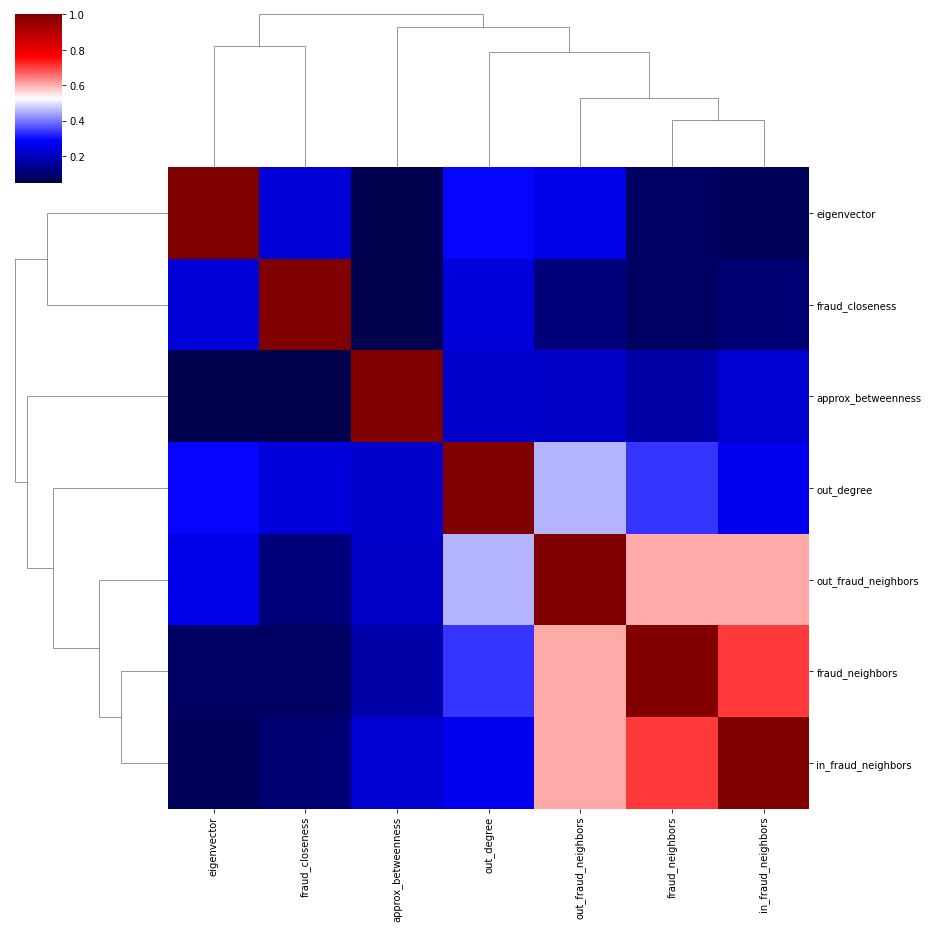

In [72]:
XTRAIN_with_graph.columns = XTRAIN_with_graph.columns.astype(str)
temp = XTRAIN_with_graph.sample(500)
daml_obj.explain_model(temp,type="training")